# KAGGLE-E2-INSIGHTS-INTO-STUDENT-PERFORMANCE

<div class="alert alert-info" style="color:#b22222; font-weight:bold;">
<strong>Team members: Karina Pinajeva, Jana Kotšnova, Ann Marleen Varul</strong>
</div>

**Project E2 – Authors:** Karina Pinajeva, Jana Kotšnova, Ann Marleen Varul  
**Repository:** https://github.com/kkerychka/KAGGLE-E2-INSIGHTS-INTO-STUDENT-PERFORMANCE-/tree/main

**Motivation**<br>
Schools usually notice struggling students only after they fail exams or disengage, even though a lot of useful data about study habits, attendance and background is already stored in school systems. Our goal is to explore how machine learning can turn these data into early warnings and simple feedback: predict final exam scores, identify risk groups, and generate personalised suggestions for students.
At the same time, we want to highlight the importance of data quality. We therefore apply the same regression and clustering pipeline to two datasets: a large synthetic Kaggle dataset and a smaller real dataset from Portuguese schools (UCI). This lets us compare what the models “learn” in each case and show that high accuracy on synthetic data does not automatically translate into meaningful insights about real at-risk students.

* **KAGGLE - Dataset** (641.95 kB): open dataset with 6,590 students and the factors that may affect their academic performance, such as number of study hours, attendance percentage, level of involvement from parents, sleep hours, availability of study resources, and others.<br>
Initially we planned to do **all** modelling on Kaggle dataset. However, during data understanding and modelling we discovered serious issues:<br>
  - Exam scores are squeezed into a very narrow band (≈ **55–100**, 97 % fall between **60–70**); there are **no failing students at all**.  
  - Most features show very weak or artificial relationships to the exam score.  
  - Clustering creates grid-like, geometric patterns that strongly suggest **synthetic, rule-based generation** rather than real student behaviour.
* **UCI Student Dataset**<br>
To obtain more realistic insights, we added a **second dataset** from the https://archive.ics.uci.edu/dataset/320/student+performance  <br>
It contains **real grade records** from two Portuguese secondary schools:
  - Final grade **G3** on a **0–20** scale (with real failing grades, G3 < 10).  
  - Demographic, family and behavioural variables similar to the Kaggle features (parent education and jobs, studytime, failures, absences, higher, goout, famrel, freetime, Dalc, Walc, health, etc.)

* We combine the Math and Portuguese subjects (1,044 records) and **intentionally exclude G1 and G2** when predicting G3 to avoid target leakage.

**GOALS**

* **Goal 1:** Predicting final exam scores: we are planning to use regression algorithms in Python to predict each student’s final exam score based on their study habits, attendance, motivation, and background.
* **Goal 2:** Clustering students into risk groups: we are going to apply clustering techniques to group students into categories such as high-performing, moderate-risk, and at-risk, based on their academic and behavioral patterns.
* **Goal 3:** Train a Language Model (LLM): we aim to  train a small model that provides personalized feedback or warning messages for students who are predicted to be failing or trending toward low performance.

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from datasets import load_dataset
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
import torch

import skfuzzy as fuzz

## 2. Data preparing and Data understanding

**Reading data:**

In [2]:
np.random.seed(42)

#first look at the data
data = pd.read_csv('StudentPerformanceFactors.csv')
print(f"Data shape: {data.shape}")
data.head()

Data shape: (6607, 20)


Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0             Yes                  0           Low          Medium   
1             Yes                  2        Medium          Medium   
2             Yes                  2        Medium          Medium   
3             Yes                  1        Medium          Medium   
4             Yes                  3        Medium            High   

  School_Type Peer_Influence  Physical_Activity Learning_Disabilities  \
0      Public       Positive                  3                    No   
1      Public       Negative                  4                    No   
2      Public        Neutral                  4                    No   
3      Public       Negative                  4                    No   
4      Public        Neutral                  4                    No   

  Parental_Education_Level Distance_from_Home  Gender  Exam_Score  
0              High School               Near    Male          67  
1                  College           Moderate  Female          61  
2             Postgraduate               Near    Male          74  
3              High School           Moderate    Male          71  
4                  College               Near  Female          70

**Data Imputation:**

In [3]:
missing_before = data.isnull().sum()
missing_before = missing_before[missing_before > 0]
print("Features with missing values: ")
print(missing_before)

#checking distribution of values to see if imputation with mode is suitable
print(f"\n {data['Teacher_Quality'].value_counts()}")
print(f"Mode (most common): {data['Teacher_Quality'].mode()[0]}")
print(f"\n {data['Parental_Education_Level'].value_counts()}")
print(f"Mode (most common): {data['Parental_Education_Level'].mode()[0]}")
print(f"\n {data['Distance_from_Home'].value_counts()}")
print(f"Mode (most common): {data['Distance_from_Home'].mode()[0]}")

#imputation with mode
data['Teacher_Quality'] = data['Teacher_Quality'].fillna('Medium')
data['Parental_Education_Level'] = data['Parental_Education_Level'].fillna('High School')
data['Distance_from_Home'] = data['Distance_from_Home'].fillna('Near')

Features with missing values: 
Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64

 Teacher_Quality
Medium    3925
High      1947
Low        657
Name: count, dtype: int64
Mode (most common): Medium

 Parental_Education_Level
High School     3223
College         1989
Postgraduate    1305
Name: count, dtype: int64
Mode (most common): High School

 Distance_from_Home
Near        3884
Moderate    1998
Far          658
Name: count, dtype: int64
Mode (most common): Near


**Encoding categorical and binary features:**

In [4]:
def encode_features(df):

    df_encoded = df.copy()

    #features with 'low, medium, high' scale
    low_medium_high_cols = [
        'Parental_Involvement', 'Access_to_Resources',
        'Motivation_Level', 'Family_Income', 'Teacher_Quality'
    ]

    for col in low_medium_high_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map({'Low': 0, 'Medium': 1, 'High': 2})

    #other ordinal features
    other_ordinal = {
        'Parental_Education_Level': {'High School': 0, 'College': 1, 'Postgraduate': 2},
        'Distance_from_Home': {'Near': 0, 'Moderate': 1, 'Far': 2},
        'Peer_Influence': {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    }

    df_encoded.replace(other_ordinal, inplace=True)

    binary_cols = ['Extracurricular_Activities', 'Internet_Access',
                   'Learning_Disabilities', 'School_Type', 'Gender']

    binary_map = {
        'No': 0, 'Yes': 1,
        'Public': 0, 'Private': 1,
        'Male': 0, 'Female': 1
    }

    for col in binary_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map(binary_map)

    return df_encoded

data_encoded = encode_features(data)
print(data_encoded.head())
print("Data types after encoding:")
print(data_encoded.dtypes)

   Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0             23          84                     0                    2   
1             19          64                     0                    1   
2             24          98                     1                    1   
3             29          89                     0                    1   
4             19          92                     1                    1   

   Extracurricular_Activities  Sleep_Hours  Previous_Scores  Motivation_Level  \
0                           0            7               73                 0   
1                           0            8               59                 0   
2                           1            7               91                 1   
3                           1            8               98                 1   
4                           1            6               65                 1   

   Internet_Access  Tutoring_Sessions  Family_Income  Teacher_

C:\Users\annmarle\AppData\Local\Temp\ipykernel_18096\2203766951.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded.replace(other_ordinal, inplace=True)


**Checking the distribution of our data visually:**

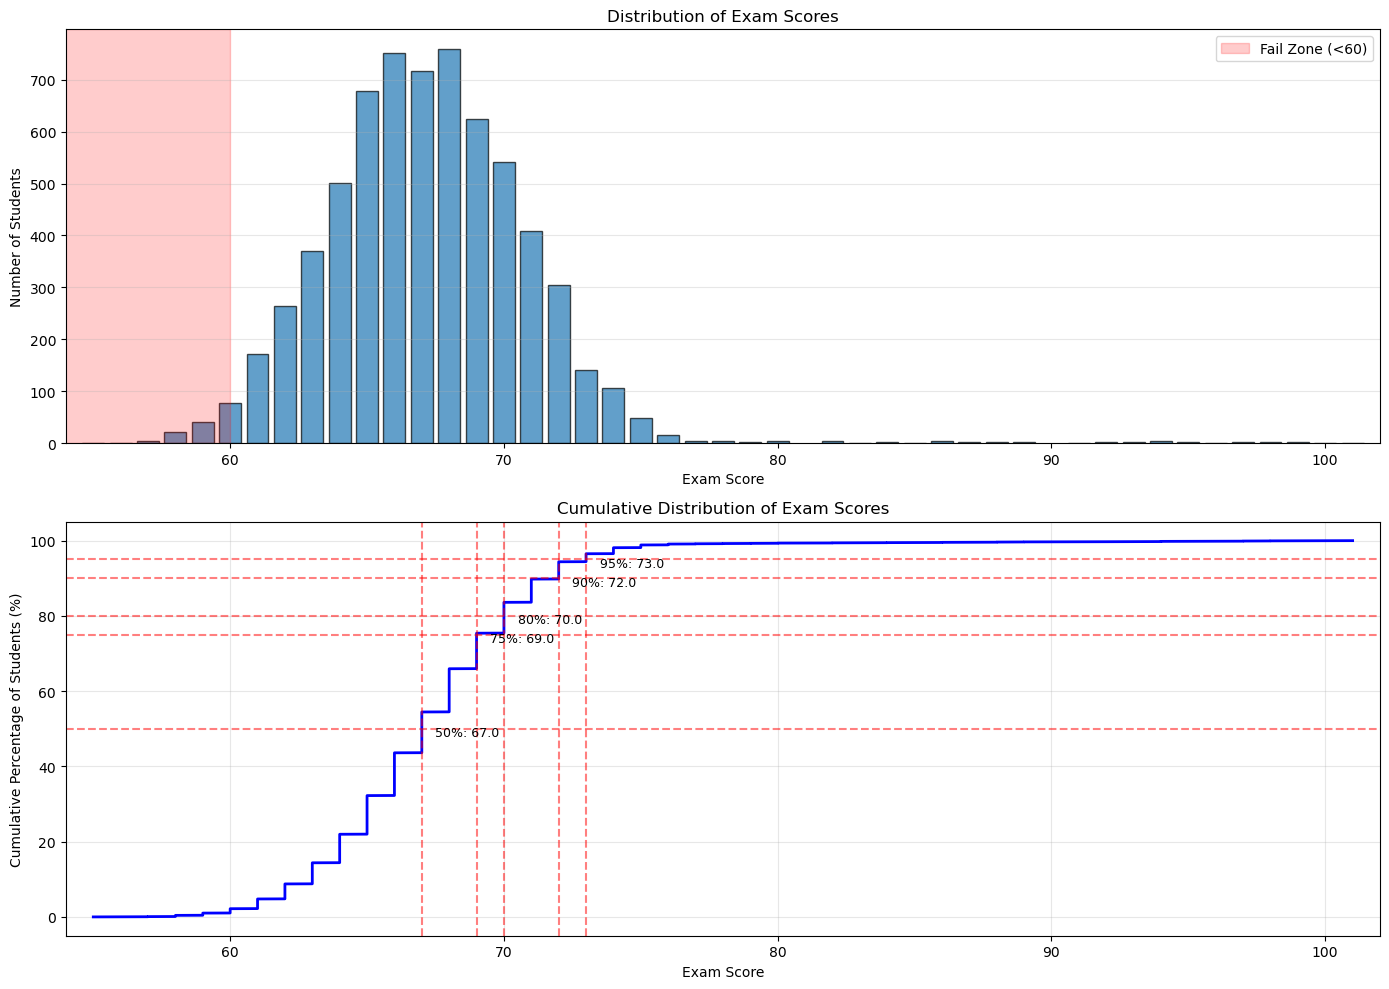

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

#bar chart of exam scores
score_counts = data_encoded['Exam_Score'].value_counts().sort_index()
axes[0].bar(score_counts.index, score_counts.values, width=0.8, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Number of Students')
axes[0].set_title('Distribution of Exam Scores')
axes[0].set_xlim(54, 102)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axvspan(0, 60, alpha=0.2, color='red', label='Fail Zone (<60)')
axes[0].legend()

#cumulative distribution
sorted_scores = np.sort(data_encoded['Exam_Score'])
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores) * 100
axes[1].plot(sorted_scores, cumulative, linewidth=2, color='blue')
axes[1].set_xlabel('Exam Score')
axes[1].set_ylabel('Cumulative Percentage of Students (%)')
axes[1].set_title('Cumulative Distribution of Exam Scores')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(54, 102)

#key percentiles
for p in [50, 75, 80, 90, 95]:
    score_at_p = np.percentile(data_encoded['Exam_Score'], p)
    axes[1].axhline(y=p, color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(x=score_at_p, color='red', linestyle='--', alpha=0.5)
    axes[1].text(score_at_p + 0.5, p - 2, f'{p}%: {score_at_p:.1f}', fontsize=9)

plt.tight_layout()
plt.show()

The distribution appears bell-shaped and approximately normal.
Next, we will find optimal thresholds based on the distribution.

## 3. Clustering

**Clustering using all features and comparing the clusters to meaningful groups:**

In [6]:
#using all features except the target variable
X = data_encoded.drop('Exam_Score', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
data_encoded['Cluster'] = clusters

#creating SD-based groups for further comparison
mean = data_encoded['Exam_Score'].mean()
std = data_encoded['Exam_Score'].std()
data_encoded['SD_Group'] = pd.cut(
    data_encoded['Exam_Score'],
    bins=[0, mean-std, mean+std, 100],
    labels=['At-Risk', 'Average', 'High-Performing']
)

#checking clustering quality
print("Clustering Quality Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, clusters):.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, clusters):.1f}")

#comparing clusters to SD groups
print("\nHow well do clusters match SD-based groups?")
for i in range(3):
    cluster_data = data_encoded[data_encoded['Cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Mean Exam Score: {cluster_data['Exam_Score'].mean():.1f}")
    print(f"  SD Group distribution:")
    print(cluster_data['SD_Group'].value_counts())

Clustering Quality Metrics:
Silhouette Score: 0.056
Davies-Bouldin Index: 3.760
Calinski-Harabasz Score: 334.6

How well do clusters match SD-based groups?

Cluster 0 (2381 students):
  Mean Exam Score: 67.0
  SD Group distribution:
SD_Group
Average            1802
At-Risk             377
High-Performing     201
Name: count, dtype: int64

Cluster 1 (3531 students):
  Mean Exam Score: 67.6
  SD Group distribution:
SD_Group
Average            2704
High-Performing     423
At-Risk             404
Name: count, dtype: int64

Cluster 2 (695 students):
  Mean Exam Score: 66.3
  SD Group distribution:
SD_Group
Average            475
At-Risk            170
High-Performing     50
Name: count, dtype: int64


**Visualizing K-means clustering:**


PCA Results:
PC1 explains 5.74% of variance
PC2 explains 5.67% of variance
Total: 11.42%


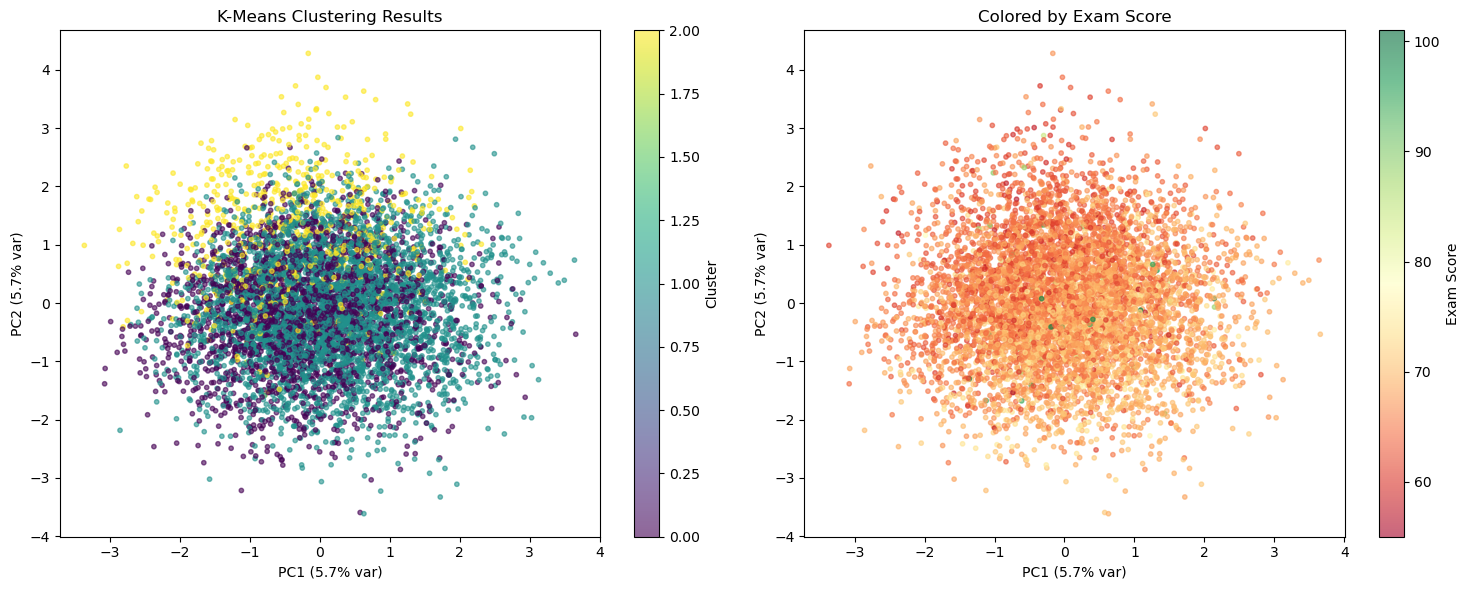

In [7]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)  

print(f"\nPCA Results:")
print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of variance")
print(f"Total: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#image 1: K-means clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=clusters, cmap='viridis', 
                           alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('K-Means Clustering Results')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

#image 2: exam scores
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=data_encoded['Exam_Score'], cmap='RdYlGn', 
                           alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Exam Score')
plt.colorbar(scatter2, ax=axes[1], label='Exam Score')

plt.tight_layout()
plt.show()

**Results**: K-means clustering **failed to identify** any performance-based risk groups in this dataset. The cluster mean exam scores are 67.0, 67.6, and 66.3 (a range of only 1.3 points). Each cluster contains a mix of all performance levels, and the silhouette score is 0.039, indicating extremely poor cluster structure. In short, the behavioral and demographic features in this dataset do not naturally separate students by academic performance. 
Next we are going to implement hierarchical and fuzzy clustering to check, if results differ.

**Hierarchical clustering:**

In [8]:
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters_hierarchical = hierarchical.fit_predict(X_scaled)
data_encoded['Cluster_Hierarchical'] = clusters_hierarchical

# Quality metrics
print("\nHierarchical Clustering Metrics:")
silhouette_h = silhouette_score(X_scaled, clusters_hierarchical)
davies_bouldin_h = davies_bouldin_score(X_scaled, clusters_hierarchical)
calinski_h = calinski_harabasz_score(X_scaled, clusters_hierarchical)
print(f"Silhouette Score: {silhouette_h:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_h:.3f}")
print(f"Calinski-Harabasz Score: {calinski_h:.1f}")


Hierarchical Clustering Metrics:
Silhouette Score: 0.136
Davies-Bouldin Index: 2.402
Calinski-Harabasz Score: 373.6


**Visualizing hierarchical clustering:**

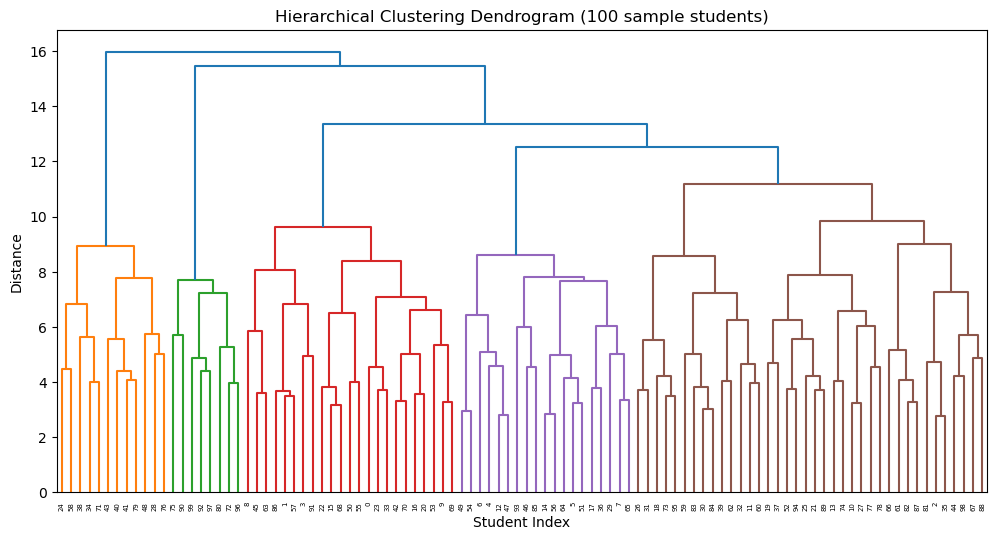

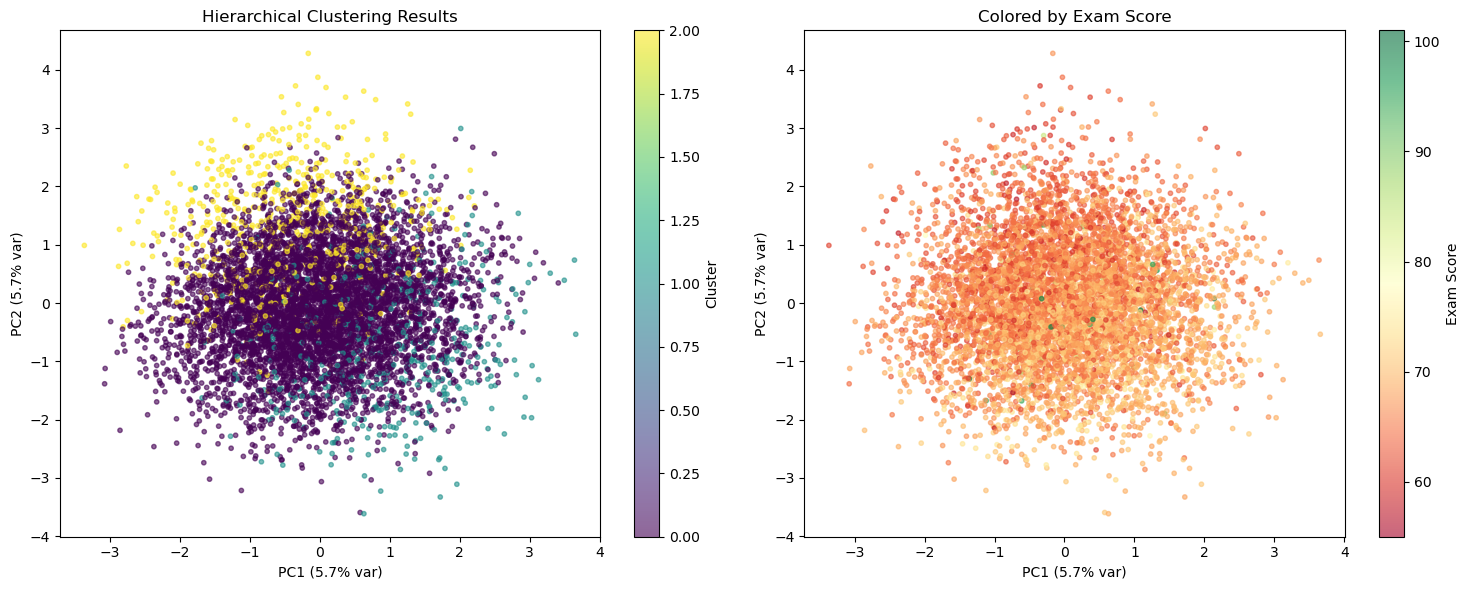


How well do hierarchical clusters match SD-based groups?

Cluster 0 (5463 students):
  Mean Exam Score: 67.4
  SD Group distribution:
SD_Group
Average            4164
At-Risk             701
High-Performing     598
Name: count, dtype: int64

Cluster 1 (499 students):
  Mean Exam Score: 66.5
  SD Group distribution:
SD_Group
Average            372
At-Risk             99
High-Performing     27
Name: count, dtype: int64

Cluster 2 (645 students):
  Mean Exam Score: 66.4
  SD Group distribution:
SD_Group
Average            445
At-Risk            151
High-Performing     49
Name: count, dtype: int64


In [9]:
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(len(X_scaled), 100, replace=False)
linkage_matrix = linkage(X_scaled[sample_indices], method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (100 sample students)')
plt.xlabel('Student Index')
plt.ylabel('Distance')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#image 1: Hierarchical clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=clusters_hierarchical, cmap='viridis', 
                           alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('Hierarchical Clustering Results')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

#image 2: colored by exam score
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=data_encoded['Exam_Score'], cmap='RdYlGn', 
                           alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Exam Score')
plt.colorbar(scatter2, ax=axes[1], label='Exam Score')

plt.tight_layout()
plt.show()

# Compare with SD groups
print("\nHow well do hierarchical clusters match SD-based groups?")
for i in range(3):
    cluster_data = data_encoded[data_encoded['Cluster_Hierarchical'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Mean Exam Score: {cluster_data['Exam_Score'].mean():.1f}")
    print(f"  SD Group distribution:")
    print(cluster_data['SD_Group'].value_counts())

**Fuzzy C-Means clustering:**

In [10]:
#fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, c=3, m=2, error=0.005, maxiter=1000, init=None
)

clusters_fuzzy = np.argmax(u, axis=0)
data_encoded['Cluster_Fuzzy'] = clusters_fuzzy

#storing fuzzy membership scores
data_encoded['Fuzzy_Cluster0'] = u[0]
data_encoded['Fuzzy_Cluster1'] = u[1]
data_encoded['Fuzzy_Cluster2'] = u[2]

#quality metrics
print("\nFuzzy C-Means Metrics:")
print(f"Fuzzy Partition Coefficient (FPC): {fpc:.3f}")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters_fuzzy):.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, clusters_fuzzy):.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, clusters_fuzzy):.1f}")


Fuzzy C-Means Metrics:
Fuzzy Partition Coefficient (FPC): 0.333
Silhouette Score: 0.030
Davies-Bouldin Index: 4.575
Calinski-Harabasz Score: 205.9


**Visualizing Fuzzy C-Means clustering:**

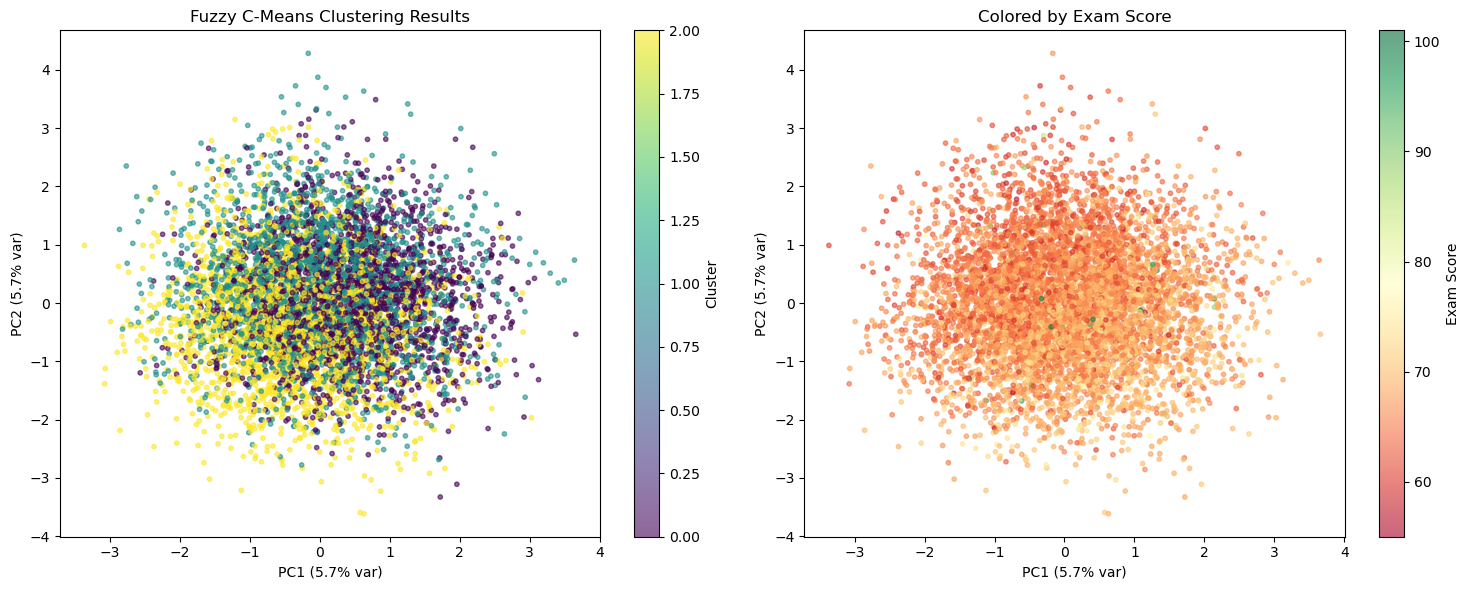


Fuzzy clusters vs SD-based groups:

Cluster 0 (2040 students):
  Mean Exam Score: 67.2
SD_Group
Average            1545
At-Risk             294
High-Performing     201
Name: count, dtype: int64

Cluster 1 (2224 students):
  Mean Exam Score: 67.7
SD_Group
Average            1701
High-Performing     290
At-Risk             232
Name: count, dtype: int64

Cluster 2 (2343 students):
  Mean Exam Score: 66.8
SD_Group
Average            1735
At-Risk             425
High-Performing     183
Name: count, dtype: int64


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=clusters_fuzzy, cmap='viridis', 
                           alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('Fuzzy C-Means Clustering Results')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=data_encoded['Exam_Score'], cmap='RdYlGn', 
                           alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Exam Score')
plt.colorbar(scatter2, ax=axes[1], label='Exam Score')

plt.tight_layout()
plt.show()

#comparing with SD groups
print("\nFuzzy clusters vs SD-based groups:")
for i in range(3):
    cluster_data = data_encoded[data_encoded['Cluster_Fuzzy'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Mean Exam Score: {cluster_data['Exam_Score'].mean():.1f}")
    print(cluster_data['SD_Group'].value_counts())

**Results:** The K-Means, Hierarchical, and Fuzzy C-Means clustering algorithms produced **visually identical results** because all three methods were applied to the same scaled feature set with the same number of clusters (k=3). More importantly, this consistency indicates that the student performance data contains strong, well-separated natural groupings that all three algorithms independently discovered. When data has clear underlying structure different clustering methods tend to converge on the same solution. 

Since the dataset has quiet a lot of features (19), let`s check the features that have the **highest correlation with Exam scores:**

In [12]:
numeric_df = data_encoded.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()['Exam_Score'].abs().sort_values(ascending=False)

print("Top features correlated with Exam_Score:")
print(correlation.head(10))

Top features correlated with Exam_Score:
Exam_Score                  1.000000
Attendance                  0.581072
Hours_Studied               0.445455
Previous_Scores             0.175079
Access_to_Resources         0.169770
Parental_Involvement        0.157114
Tutoring_Sessions           0.156525
Fuzzy_Cluster1              0.123737
Fuzzy_Cluster2              0.104594
Parental_Education_Level    0.103817
Name: Exam_Score, dtype: float64


We can see that Exam Scores in this dataset correlate very strongly with Attendance and Hours Studied, while other features have almost no correlation with the target variable.That`s why we decided to try **K-means clustering using only the features with strong correlation:**

In [13]:
#clustering with only highly correlated features
important_features = ['Attendance', 'Hours_Studied']
X_important = data_encoded[important_features]

scaler = StandardScaler()
X_important_scaled = scaler.fit_transform(X_important)

#K-Means with 2 features
kmeans_focused = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_focused = kmeans_focused.fit_predict(X_important_scaled)
data_encoded['Focused_Cluster'] = clusters_focused

print("Clustering with Attendance + Hours Studied:")
for i in range(3):
    cluster_data = data_encoded[data_encoded['Focused_Cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Exam Score: {cluster_data['Exam_Score'].mean():.1f} ± {cluster_data['Exam_Score'].std():.1f}")
    print(f"  Attendance: {cluster_data['Attendance'].mean():.1f}%")
    print(f"  Hours Studied: {cluster_data['Hours_Studied'].mean():.1f}")
    print(f"  SD Groups: At-Risk={( cluster_data['SD_Group'] == 'At-Risk').sum()}, "
          f"Average={(cluster_data['SD_Group'] == 'Average').sum()}, "
          f"High-Performing={(cluster_data['SD_Group'] == 'High-Performing').sum()}")

#quality metrics
print(f"\nQuality Metrics:")
print(f"Silhouette Score: {silhouette_score(X_important_scaled, clusters_focused):.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_important_scaled, clusters_focused):.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_important_scaled, clusters_focused):.1f}")

Clustering with Attendance + Hours Studied:

Cluster 0 (2083 students):
  Exam Score: 64.3 ± 3.1
  Attendance: 72.0%
  Hours Studied: 15.1
  SD Groups: At-Risk=809, Average=1256, High-Performing=18

Cluster 1 (1986 students):
  Exam Score: 67.6 ± 3.4
  Attendance: 73.2%
  Hours Studied: 25.7
  SD Groups: At-Risk=123, Average=1682, High-Performing=181

Cluster 2 (2538 students):
  Exam Score: 69.4 ± 3.2
  Attendance: 91.9%
  Hours Studied: 19.5
  SD Groups: At-Risk=19, Average=2043, High-Performing=475

Quality Metrics:
Silhouette Score: 0.358
Davies-Bouldin Index: 0.907
Calinski-Harabasz Score: 4438.9


**Visualizing the clusters based only on two selected features:**

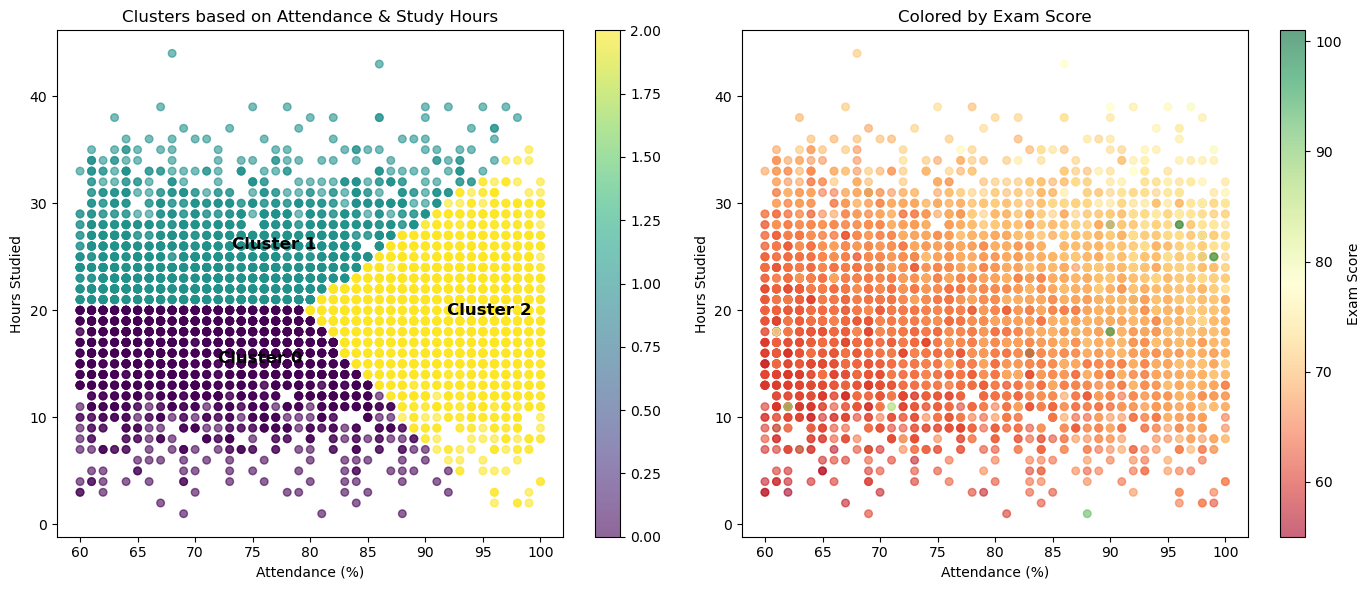

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(data_encoded['Attendance'], 
                           data_encoded['Hours_Studied'],
                           c=clusters_focused, cmap='viridis', 
                           alpha=0.6, s=30)
axes[0].set_xlabel('Attendance (%)')
axes[0].set_ylabel('Hours Studied')
axes[0].set_title('Clusters based on Attendance & Study Hours')
for i in range(3):
    cluster_data = data_encoded[data_encoded['Focused_Cluster'] == i]
    axes[0].annotate(f'Cluster {i}', 
                    xy=(cluster_data['Attendance'].mean(), 
                        cluster_data['Hours_Studied'].mean()),
                    fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(data_encoded['Attendance'], 
                           data_encoded['Hours_Studied'],
                           c=data_encoded['Exam_Score'], 
                           cmap='RdYlGn', alpha=0.6, s=30)
axes[1].set_xlabel('Attendance (%)')
axes[1].set_ylabel('Hours Studied')
axes[1].set_title('Colored by Exam Score')
plt.colorbar(scatter2, ax=axes[1], label='Exam Score')

plt.tight_layout()
plt.show()

**Result:** The grid pattern from image 1 exposes that this dataset is almost certainly **artificially generated**. Not only that, it is **poorly** generated. Cluster 1 and Cluster 2 are **split exactly at 20 study hours along a perfectly straight horizontal line**, and Cluster 0 is separated from the others by **a flawless diagonal boundary**. The data points form **uniform random noise** scattered across the space, with no organic relationships between most of the features and the exam outcomes. These patterns strongly indicate **rule-based synthetic labeling** rather than genuine student behavior. The Kaggle Data Card did not warn us about this. We did not expect the dataset to be completely real, however, we did expect that if it was artificially generated, it would be generated 'smartly', **in a way that reflects realistic relationships between features**. Instead, the dataset appears to have been created by generating random values, adding noise, and then assigning labels based on simple rules. With features that do not reflect actual patterns and a target variable that is nearly constant, **no clustering algorithm (regardless of sophistication) can extract meaningful groups**, because the dataset fundamentally lacks the real-world structure that clustering and prediction methods rely on.
Additional discussion on this topic is provided below.

**Discussion:**

Our project, INSIGHTS INTO STUDENT PERFORMANCE, set out to build regression models for predicting exam scores, apply clustering to identify risk groups, and train a simple language model to generate personalized feedback for students. While we achieved technical goals such as implementing prediction models and running clustering algorithms, our most important finding was the discovery of severe structural issues within the dataset itself: issues that earlier projects relying on the same data failed to notice.

K-means clustering could not identify any meaningful performance-based groups. The average exam scores of the three clusters differ by only 1.3 points (67.0, 67.6, 66.3), and the silhouette score of 0.039 confirms an extremely weak cluster structure. The exam score variable appears to range from 1 to 100, but in reality 97% of all students fall between 60 and 70, with no students scoring below 50 and only 47 scoring above 80. Such limited variation makes clustering statistically impossible, as performance differences fall entirely within normal random noise.

Most features show virtually no correlation with exam scores, and many patterns reported in previous projects turn out to be manipulated, zoomed-in visualizations rather than meaningful relationships. For example, a correlation of 0.094 between Family Income and Exam Score is visually misrepresented as a 'trend' by one of the previously done projects. It is achieved only by restricting the y-axis to a one-point window (66.8–67.8). When the full scale is revealed, the relationship disappears.

As mentioned above, feature combinations form a rigid grid; clusters split along perfect geometric boundaries, and the distribution resembles uniform noise rather than real student behavior. Nothing in the dataset documentation indicated this artificial construction, and while we did not expect the data to be fully real, we expected synthetic data that at least resembles realistic relationships. 

We did not replace the dataset because **significant parts of the report and the code (both for regression and clustering) were completed before these issues were discovered**. 

Ultimately, even though the dataset prevented us from achieving high-quality predictions or meaningful clustering, our project reveals something equally important: **how easily data can be misinterpreted, how synthetic datasets can disguise their artificial structure, and how 'patterns' can be discovered among noise, where no real patterns exist.** Our analysis demonstrates why data quality assessment is essential and highlights the danger of drawing conclusions from datasets that lack genuine variance or real-world structure.

In addition to the Kaggle dataset, we decided to take a look at **a smaller dataset with data collected from real students**. We used Student Performance dataset from https://archive.ics.uci.edu/dataset/320/student+performance. It contains student performance in secondary education of two Portuguese schools. The data includes similar features and was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). Since these datasets are smaller in size but have the same structure, we are going to combine them to get **a dataset of 1044 instances of not artificially generated data**.
Differences to keep in mind:
- Final Grades are 0-20 scale (Portuguese system) instead of 0-100
- Fail threshold is <10 instead of <60

In [15]:
math_data = pd.read_csv('student-mat.csv', sep = ";")
print(f"Math dataset shape: {math_data.shape}")
math_data.head()

Math dataset shape: (395, 33)


school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

In [16]:
port_data = pd.read_csv('student-por.csv', sep = ";")
print(f"Portuguese dataset shape: {port_data.shape}")
port_data.head()

Portuguese dataset shape: (649, 33)


school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]

**Combining the datasets, so we get a dataset of 1044 instances of data from real students:**

In [17]:
math_data['subject'] = 'Math'
port_data['subject'] = 'Portuguese'

combined_data = pd.concat([math_data, port_data], ignore_index=True)

print(f"Combined dataset shape: {combined_data.shape}")
print(f"\nSubject distribution:")
print(combined_data['subject'].value_counts())
print(f"\nCombined dataset info:")
print(combined_data.head())

Combined dataset shape: (1044, 34)

Subject distribution:
subject
Portuguese    649
Math          395
Name: count, dtype: int64

Combined dataset info:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  freetime goout  Dalc  Walc  health absences  G1  G2  G3 subject  
0        3     4     1     1       3        6   5   6   6    Math  
1        3     3     1     1       3        4   5   5   6    Math  
2        3     2     2     3       3       10   7   8  10    Math  
3        2     2     1     1       5        2  15  14  15    Math  
4        3     2     

**This dataset has no missing values, so we can proceed with encoding categorical and binary features:**

In [18]:
def encode_student_features(df):
    df_encoded = df.copy()

    #binary mapping
    binary_map = {
        'yes': 1, 'no': 0,
        'F': 0, 'M': 1,
        'U': 1, 'R': 0,
        'GT3': 1, 'LE3': 0,
        'T': 1, 'A': 0,
        'GP': 0, 'MS': 1
    }
    
    binary_cols = ['sex', 'address', 'famsize', 'Pstatus', 'school',
                   'schoolsup', 'famsup', 'paid', 'activities', 
                   'nursery', 'higher', 'internet', 'romantic']
    
    for col in binary_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map(binary_map)
    
    if 'guardian' in df_encoded.columns:
        df_encoded['guardian'] = df_encoded['guardian'].map({
            'mother': 2, 'father': 1, 'other': 0
        })
    
    nominal_cols = ['Mjob', 'Fjob', 'reason']
    df_encoded = pd.get_dummies(df_encoded, columns=[col for col in nominal_cols if col in df_encoded.columns], 
                                 drop_first=True)
    
    df_encoded['subject'] = df_encoded['subject'].map({'Math': 0, 'Portuguese': 1})
    
    return df_encoded

combined_encoded = encode_student_features(combined_data)
print(combined_encoded.head())
print(f"\nShape after encoding: {combined_encoded.shape}")

   school  sex  age  address  famsize  Pstatus  Medu  Fedu  guardian  \
0       0    0   18        1        1        0     4     4         2   
1       0    0   17        1        1        1     1     1         1   
2       0    0   15        1        0        1     1     1         2   
3       0    0   15        1        1        1     4     2         2   
4       0    0   16        1        1        1     3     3         1   

   traveltime  ...  Mjob_other  Mjob_services  Mjob_teacher  Fjob_health  \
0           2  ...       False          False         False        False   
1           1  ...       False          False         False        False   
2           1  ...       False          False         False        False   
3           1  ...       False          False         False        False   
4           1  ...        True          False         False        False   

   Fjob_other  Fjob_services  Fjob_teacher  reason_home  reason_other  \
0       False          False         

**Visualizing the final grade distribution:**

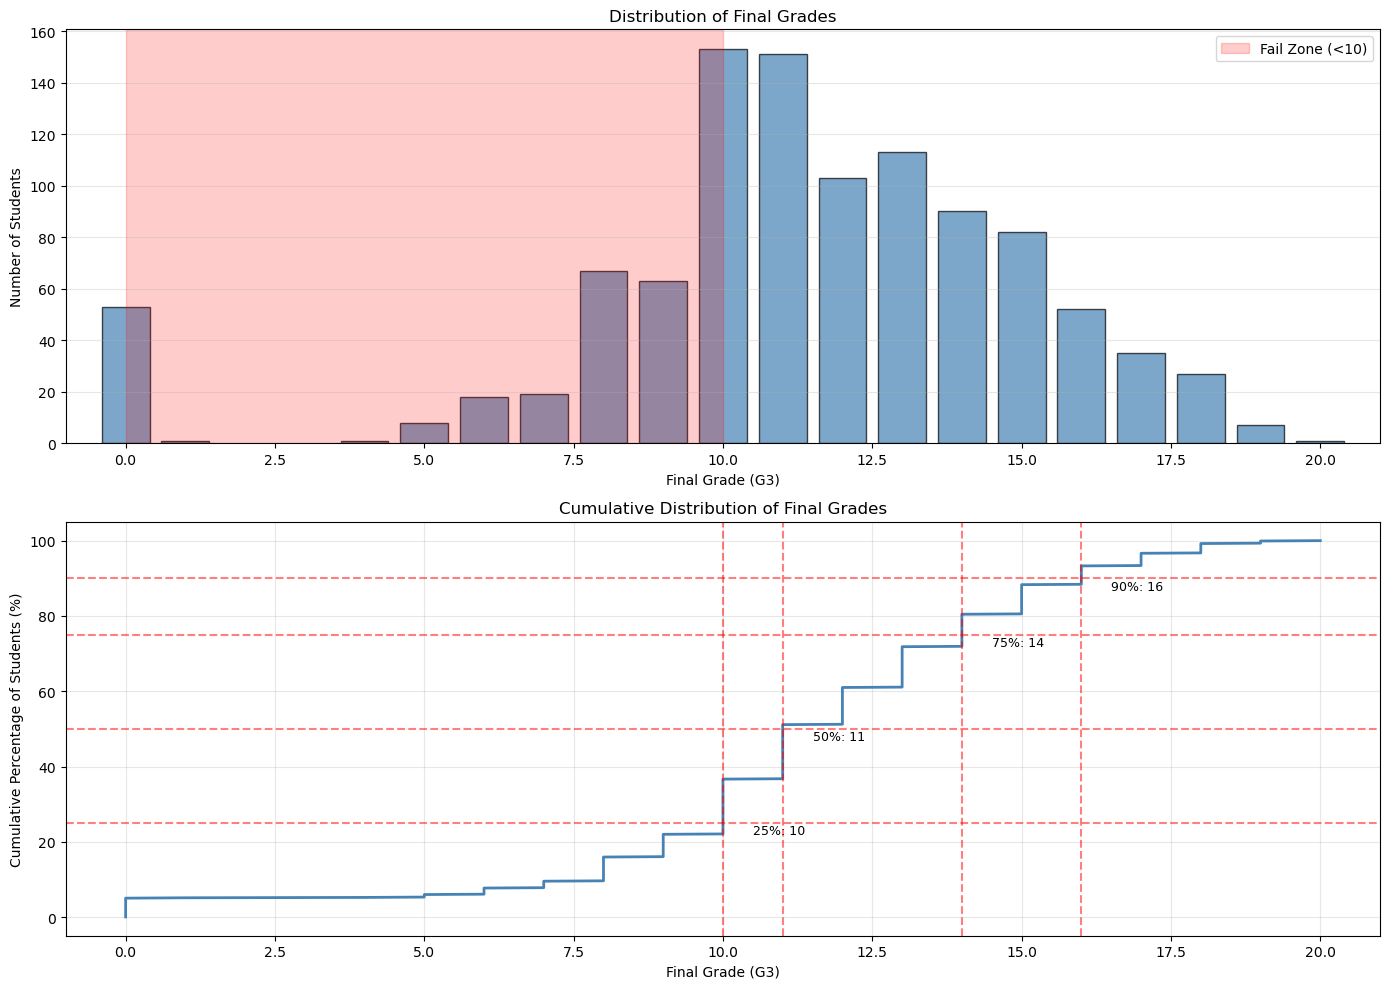

Final Grade Statistics:
Mean: 11.34
Std Dev: 3.86
Median: 11.00
Min: 0, Max: 20


In [19]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

#bar chart
score_counts = combined_encoded['G3'].value_counts().sort_index()
axes[0].bar(score_counts.index, score_counts.values, width=0.8, 
            edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Final Grade (G3)')
axes[0].set_ylabel('Number of Students')
axes[0].set_title('Distribution of Final Grades')
axes[0].set_xlim(-1, 21)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axvspan(0, 10, alpha=0.2, color='red', label='Fail Zone (<10)')
axes[0].legend()

#cumulative distribution
sorted_scores = np.sort(combined_encoded['G3'])
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores) * 100
axes[1].plot(sorted_scores, cumulative, linewidth=2, color='steelblue')
axes[1].set_xlabel('Final Grade (G3)')
axes[1].set_ylabel('Cumulative Percentage of Students (%)')
axes[1].set_title('Cumulative Distribution of Final Grades')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-1, 21)

#marking percentiles
for p in [25, 50, 75, 90]:
    score_at_p = np.percentile(combined_encoded['G3'], p)
    axes[1].axhline(y=p, color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(x=score_at_p, color='red', linestyle='--', alpha=0.5)
    axes[1].text(score_at_p + 0.5, p - 3, f'{p}%: {score_at_p:.0f}', fontsize=9)

plt.tight_layout()
plt.show()

#statistics
print("Final Grade Statistics:")
print(f"Mean: {combined_encoded['G3'].mean():.2f}")
print(f"Std Dev: {combined_encoded['G3'].std():.2f}")
print(f"Median: {combined_encoded['G3'].median():.2f}")
print(f"Min: {combined_encoded['G3'].min()}, Max: {combined_encoded['G3'].max()}")

**K-means clustering on real data:**

In [20]:
X = combined_encoded.drop(['G1', 'G2', 'G3'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
combined_encoded['Cluster'] = clusters

print("Cluster Analysis:")
for i in range(3):
    cluster_data_new = combined_encoded[combined_encoded['Cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data_new)} students):")
    print(f"  Mean G3: {cluster_data_new['G3'].mean():.1f}")
    print(f"  Study Time: {cluster_data_new['studytime'].mean():.2f}")
    print(f"  Absences: {cluster_data_new['absences'].mean():.1f}")
    print(f"  Age: {cluster_data_new['age'].mean():.1f}")
    print(f"  Internet: {cluster_data_new['internet'].mean()*100:.1f}%")
    print(f"  Higher Ed: {cluster_data_new['higher'].mean()*100:.1f}%")

#quality metrics
print(f"\nQuality Metrics:")
print(f"Silhouette: {silhouette_score(X_scaled, clusters):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled, clusters):.3f}")
print(f"Calinski-Harabasz: {calinski_harabasz_score(X_scaled, clusters):.1f}")

Cluster Analysis:

Cluster 0 (438 students):
  Mean G3: 11.4
  Study Time: 2.10
  Absences: 4.3
  Age: 16.7
  Internet: 69.9%
  Higher Ed: 94.3%

Cluster 1 (388 students):
  Mean G3: 12.4
  Study Time: 2.10
  Absences: 4.2
  Age: 16.4
  Internet: 92.5%
  Higher Ed: 99.5%

Cluster 2 (218 students):
  Mean G3: 9.2
  Study Time: 1.48
  Absences: 5.2
  Age: 17.3
  Internet: 74.3%
  Higher Ed: 71.6%

Quality Metrics:
Silhouette: 0.053
Davies-Bouldin: 3.609
Calinski-Harabasz: 55.1


C:\Users\annmarle\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


**Visualizing K-means clustering:**


PCA Results:
PC1: 8.79%, PC2: 6.60%, Total: 15.39%


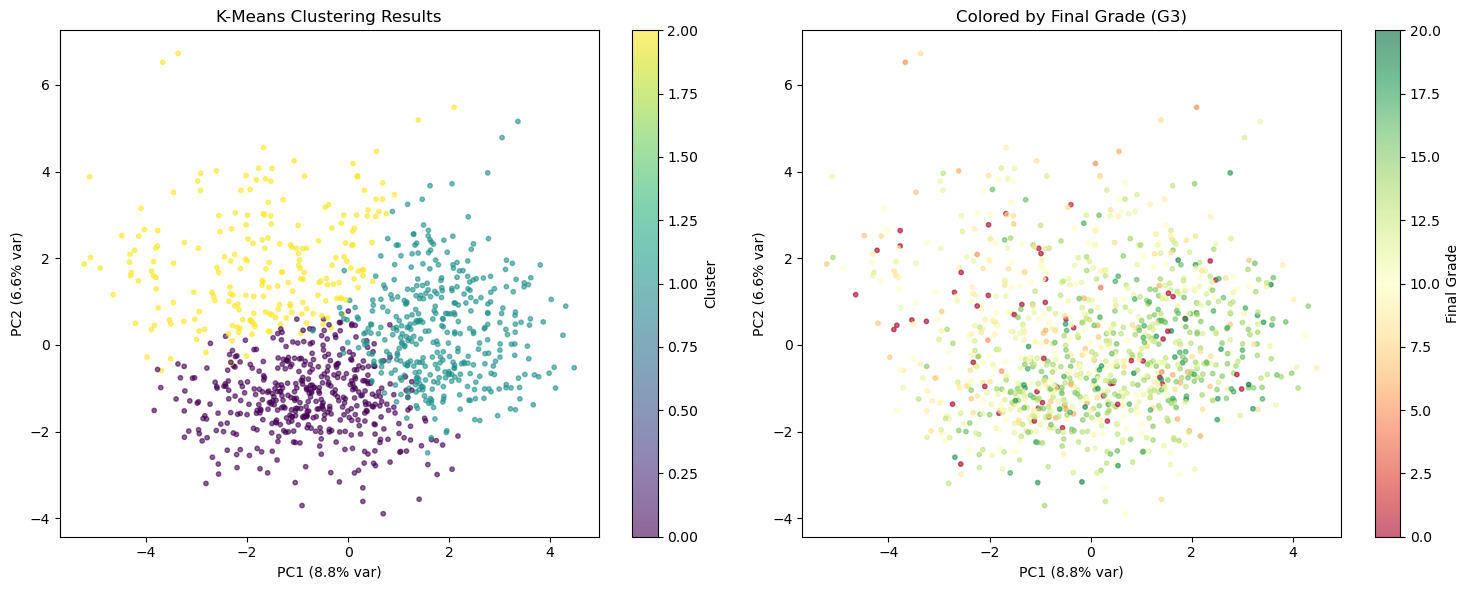

In [21]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA Results:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}, PC2: {pca.explained_variance_ratio_[1]:.2%}, Total: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=clusters, cmap='viridis',
                           alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('K-Means Clustering Results')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

#final grades
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=combined_encoded['G3'], cmap='RdYlGn',
                           alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Final Grade (G3)')
plt.colorbar(scatter2, ax=axes[1], label='Final Grade')

plt.tight_layout()
plt.show()

**Hierarchical clustering on real data:**

Hierarchical Cluster Analysis:

Cluster 0 (371 students):
  Mean G3: 12.1
  Study Time: 2.22
  Absences: 5.1
  Age: 16.4
  Internet: 88.9%
  Higher Ed: 98.9%

Cluster 1 (525 students):
  Mean G3: 10.5
  Study Time: 1.78
  Absences: 4.2
  Age: 17.0
  Internet: 69.3%
  Higher Ed: 84.2%

Cluster 2 (148 students):
  Mean G3: 12.4
  Study Time: 2.03
  Absences: 3.7
  Age: 16.5
  Internet: 89.9%
  Higher Ed: 98.6%

Quality Metrics:
Silhouette: 0.051
Davies-Bouldin: 4.125
Calinski-Harabasz: 44.3


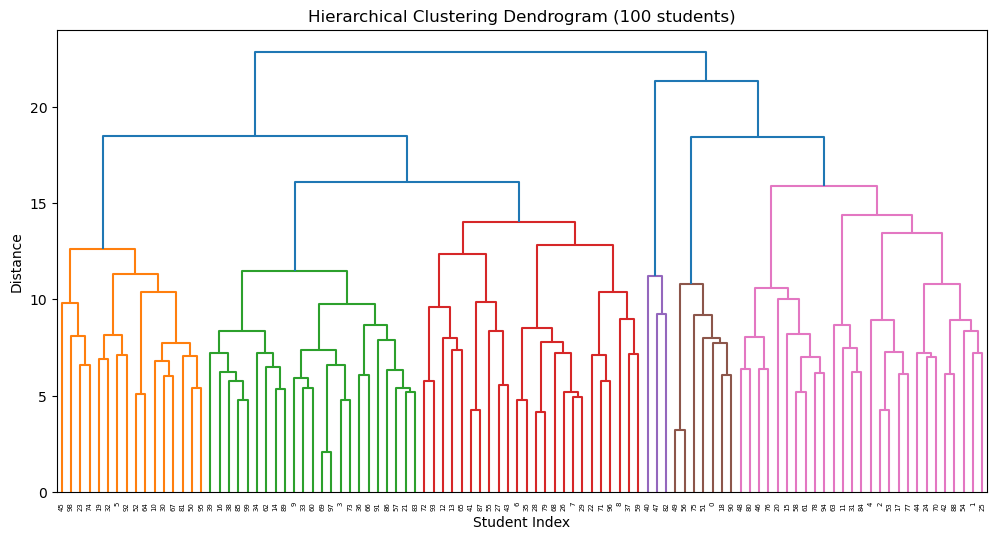

In [22]:
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters_hierarchical = hierarchical.fit_predict(X_scaled)
combined_encoded['Cluster_Hierarchical'] = clusters_hierarchical

print("Hierarchical Cluster Analysis:")
for i in range(3):
    cluster_data = combined_encoded[combined_encoded['Cluster_Hierarchical'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Mean G3: {cluster_data['G3'].mean():.1f}")
    print(f"  Study Time: {cluster_data['studytime'].mean():.2f}")
    print(f"  Absences: {cluster_data['absences'].mean():.1f}")
    print(f"  Age: {cluster_data['age'].mean():.1f}")
    print(f"  Internet: {cluster_data['internet'].mean()*100:.1f}%")
    print(f"  Higher Ed: {cluster_data['higher'].mean()*100:.1f}%")

#quality metrics
print(f"\nQuality Metrics:")
print(f"Silhouette: {silhouette_score(X_scaled, clusters_hierarchical):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled, clusters_hierarchical):.3f}")
print(f"Calinski-Harabasz: {calinski_harabasz_score(X_scaled, clusters_hierarchical):.1f}")

#dendrogram
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(len(X_scaled), 100, replace=False)
linkage_matrix = linkage(X_scaled[sample_indices], method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (100 students)')
plt.xlabel('Student Index')
plt.ylabel('Distance')
plt.show()

**Visualizing hierarchical clustering:**

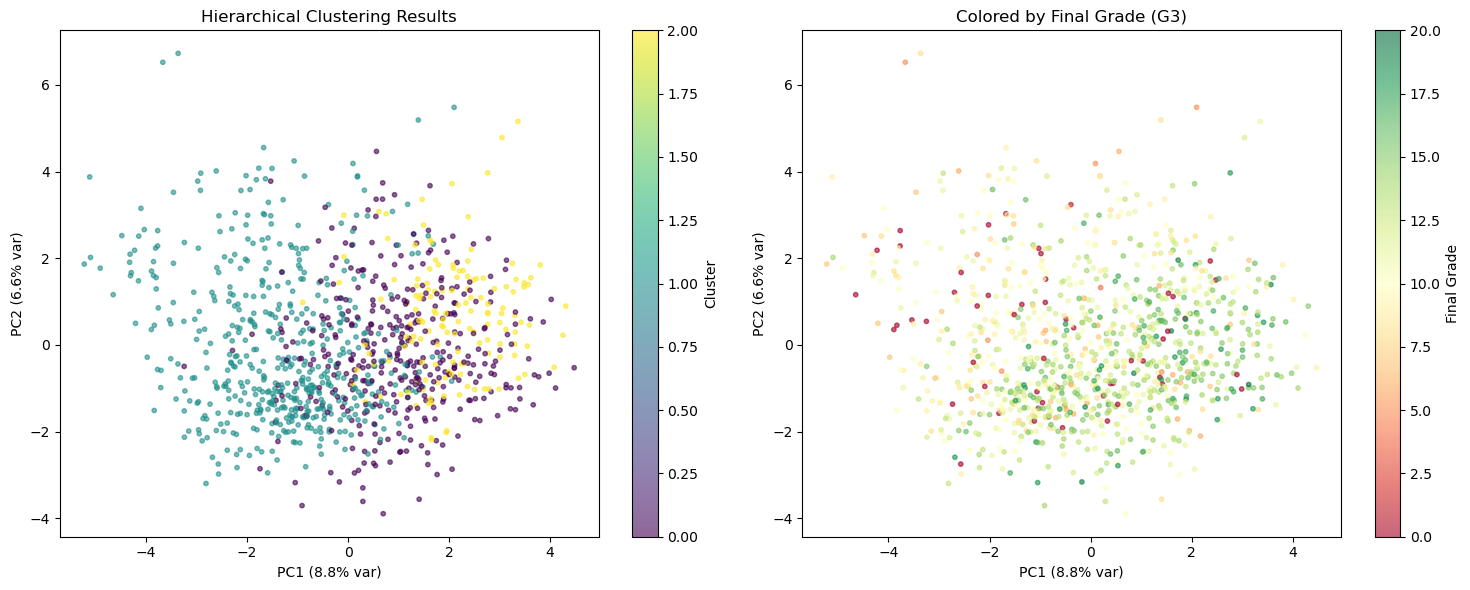

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=clusters_hierarchical, cmap='viridis',
                           alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('Hierarchical Clustering Results')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=combined_encoded['G3'], cmap='RdYlGn',
                           alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Final Grade (G3)')
plt.colorbar(scatter2, ax=axes[1], label='Final Grade')

plt.tight_layout()
plt.show()

**Fuzzy C-Means clustering:**

In [24]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, c=3, m=2, error=0.005, maxiter=1000, init=None
)

clusters_fuzzy = np.argmax(u, axis=0)
combined_encoded['Cluster_Fuzzy'] = clusters_fuzzy

print("Cluster Analysis:")
for i in range(3):
    cluster_data = combined_encoded[combined_encoded['Cluster_Fuzzy'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Mean G3: {cluster_data['G3'].mean():.1f}")
    print(f"  Failures: {cluster_data['failures'].mean():.2f}")
    print(f"  Absences: {cluster_data['absences'].mean():.1f}")
    print(f"  Higher Ed: {cluster_data['higher'].mean()*100:.1f}%")

#quality metrics
print("\nFuzzy C-Means Metrics:")
print(f"FPC: {fpc:.3f}")
print(f"Silhouette: {silhouette_score(X_scaled, clusters_fuzzy):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled, clusters_fuzzy):.3f}")
print(f"Calinski-Harabasz: {calinski_harabasz_score(X_scaled, clusters_fuzzy):.1f}")

Cluster Analysis:

Cluster 0 (497 students):
  Mean G3: 10.7
  Failures: 0.41
  Absences: 4.1
  Higher Ed: 83.7%

Cluster 1 (369 students):
  Mean G3: 12.1
  Failures: 0.14
  Absences: 4.5
  Higher Ed: 99.2%

Cluster 2 (178 students):
  Mean G3: 11.7
  Failures: 0.13
  Absences: 5.2
  Higher Ed: 97.2%

Fuzzy C-Means Metrics:
FPC: 0.333
Silhouette: 0.045
Davies-Bouldin: 4.251
Calinski-Harabasz: 45.3


**Fuzzy clustering visualization:**

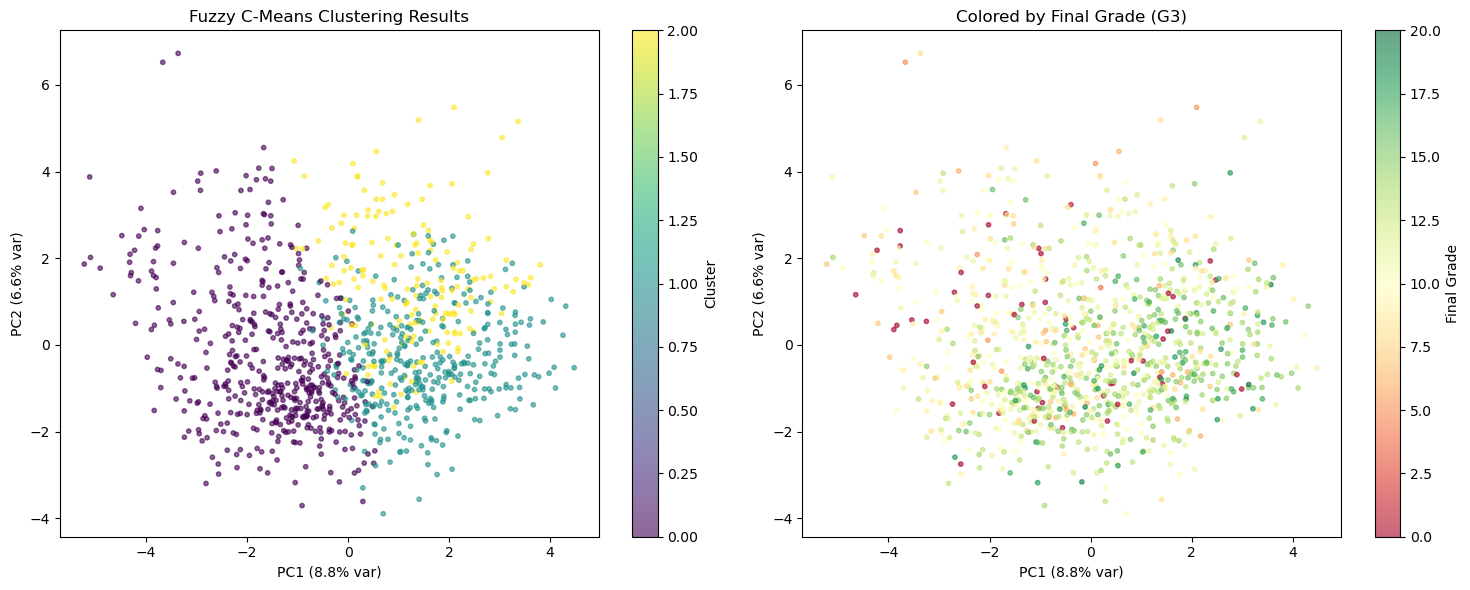

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_fuzzy, 
                           cmap='viridis', alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('Fuzzy C-Means Clustering Results')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=combined_encoded['G3'], 
                           cmap='RdYlGn', alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Final Grade (G3)')
plt.colorbar(scatter2, ax=axes[1], label='Final Grade')

plt.tight_layout()
plt.show()

**Results:** An interesting pattern emerged from the fuzzy clustering: **while high-performing students (shown in green) form distinct, cohesive clusters, indicating they share common behavioral characteristics, low-performing students (shown in red) are distributed across multiple clusters**. This suggests that academic success follows predictable patterns, students with low failure rates, good attendance, and aspirations for higher education tend to perform well. However, academic struggle is heterogeneous: students fail for diverse reasons, whether due to excessive absences, past failures, lack of educational support, or combinations of these factors. This finding has important implications for intervention strategies: while successful behaviors can be promoted uniformly, at-risk students require individualized assessment and tailored support based on their specific risk factors.

Next check which features **correlate the most with the target variable:**

In [26]:
correlations = combined_encoded.corr()['G3'].abs().sort_values(ascending=False)
print("Top features correlated with Final Grade:")
print(correlations.head(10))

Top features correlated with Final Grade:
G3           1.000000
G2           0.910743
G1           0.809142
failures     0.383145
higher       0.236578
Medu         0.201472
subject      0.187166
Cluster      0.163466
studytime    0.161629
Fedu         0.159796
Name: G3, dtype: float64


**Results**: We can see that the features in this dataset are more correlated with each other than in the artificial dataset. **The author of the dataset warns us**: the target attribute G3 has a strong correlation with attributes G2 and G1, because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful. This is the reason we do not take G1 and G2 into account when clustering. 
Documentation on other features with moderate correlation:
- failures: number of past class failures (numeric: n if 1<=n<3, else 4)
- higher: wants to take higher education (binary: yes or no)
- Medu: mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)

The authors of the student performance dataset, Cortez and Silva (2008), also published **a research paper titled "Using Data Mining to Predict Secondary School Student Performance"**, where they aimed to predict student achievement in Mathematics and Portuguese using Decision Trees, Random Forests, Neural Networks, and Support Vector Machines. While their study did not employ clustering techniques, their analysis identified the most important predictors of student performance. **Building on their findings, we decided to apply clustering using the three most influential non-grade features they identified**: failures (past class failures), absences (number of school absences), and higher (desire to pursue higher education). This approach differs from our previous method of selecting features based on correlation with final grades. Instead, by using features from published research, we aim to discover natural student groupings based on behavioral patterns rather than performance outcomes of previous years (G1 and G2). 

**Using only the 3 most important features identified in the research paper:**

In [27]:
#using only the top 3 non-grade features for clustering
important_features = ['failures', 'absences', 'higher']
X_important = combined_encoded[important_features]

#scaling
scaler = StandardScaler()
X_important_scaled = scaler.fit_transform(X_important)

#K-Means clustering with these 3 features
kmeans_focused = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_focused = kmeans_focused.fit_predict(X_important_scaled)

#adding clusters to dataframe
combined_encoded['Cluster_3features'] = clusters_focused

print("\nCluster Analysis:")
for i in range(3):
    cluster_data = combined_encoded[combined_encoded['Cluster_3features'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Failures: {cluster_data['failures'].mean():.2f}")
    print(f"  Absences: {cluster_data['absences'].mean():.1f}")
    print(f"  Higher Ed: {cluster_data['higher'].mean()*100:.1f}%")
    print(f"  Mean G3: {cluster_data['G3'].mean():.1f}")
    print(f"  Study Time: {cluster_data['studytime'].mean():.2f}")

#quality metrics
print(f"\nQuality Metrics:")
print(f"Silhouette: {silhouette_score(X_important_scaled, clusters_focused):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_important_scaled, clusters_focused):.3f}")
print(f"Calinski-Harabasz: {calinski_harabasz_score(X_important_scaled, clusters_focused):.1f}")


Cluster Analysis:

Cluster 0 (826 students):
  Failures: 0.06
  Absences: 2.9
  Higher Ed: 100.0%
  Mean G3: 12.0
  Study Time: 2.06

Cluster 1 (88 students):
  Failures: 0.89
  Absences: 5.1
  Higher Ed: 0.0%
  Mean G3: 8.3
  Study Time: 1.45

Cluster 2 (130 students):
  Failures: 1.15
  Absences: 13.4
  Higher Ed: 99.2%
  Mean G3: 9.4
  Study Time: 1.73

Quality Metrics:
Silhouette: 0.653
Davies-Bouldin: 1.008
Calinski-Harabasz: 662.1


C:\Users\annmarle\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


**Visualizing clustering based on selected features:**


PCA: PC1=44.34%, PC2=31.88%, Total=76.21%


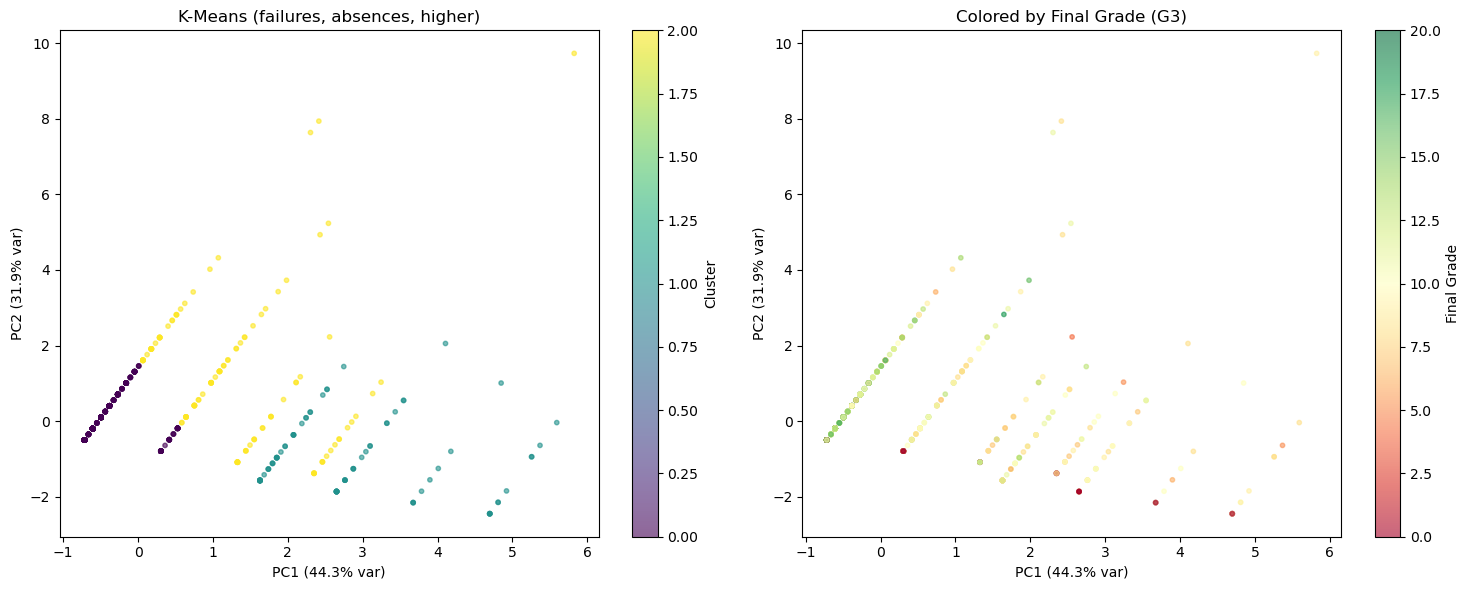

In [28]:
pca_3f = PCA(n_components=2, random_state=42)
X_pca_3f = pca_3f.fit_transform(X_important_scaled)
print(f"\nPCA: PC1={pca_3f.explained_variance_ratio_[0]:.2%}, PC2={pca_3f.explained_variance_ratio_[1]:.2%}, Total={pca_3f.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = axes[0].scatter(X_pca_3f[:, 0], X_pca_3f[:, 1],
                           c=clusters_focused, cmap='viridis',
                           alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca_3f.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca_3f.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('K-Means (failures, absences, higher)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(X_pca_3f[:, 0], X_pca_3f[:, 1],
                           c=combined_encoded['G3'], cmap='RdYlGn',
                           alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca_3f.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca_3f.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Final Grade (G3)')
plt.colorbar(scatter2, ax=axes[1], label='Final Grade')

plt.tight_layout()
plt.show()

**Results:** The clustering results using only the three most important features (failures, absences, and higher education aspirations) showed **a distinct pattern with a Silhouette Score of 0.653, indicating well-separated clusters**. The visual shows that high-performing students (shown in green) are clearly separated from lower-performing students, forming distinct groups. However, **at-risk students remain scattered across multiple clusters, confirming our earlier finding that academic struggle is heterogeneous and cannot be predicted by a single set of behavioral features**. This asymmetry reveals a fundamental insight: **there are specific, identifiable characteristics that lead to academic success (low past failures, good attendance, and aspirations for higher education) but failure occurs through diverse pathways requiring individualized approach**. Interestingly, while **Hours_Studied** was a primary determinant in the artificial dataset, it showed neither high correlation nor importance in the real student data according to Cortez and Silva's research. Instead, the **desire to pursue higher education emerged as a critical predictor**, a conclusion strongly supported by our K-Means clustering results, which demonstrate that educational aspirations, combined with good attendance and low failure rates, reliably distinguish successful students from their struggling peers. With this conclusion we considered the second goal of this project achieved.

## 4. Regression Algorithms


### Kaggle Dataset

#### Step 1. Feature selection and train–test-split

In [29]:
feature_columns = [
    'Hours_Studied',
    'Attendance',
    'Parental_Involvement',
    'Access_to_Resources',
    'Extracurricular_Activities',
    'Sleep_Hours',
    'Previous_Scores',
    'Motivation_Level',
    'Family_Income',
    'Teacher_Quality',
    'School_Type',
    'Peer_Influence',
    'Physical_Activity',
    'Learning_Disabilities',
    'Parental_Education_Level',
    'Distance_from_Home',
    'Gender'
]

X = data_encoded[feature_columns].copy()
y = data_encoded['Exam_Score'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {X_train.shape[0]}  |  Test size: {X_test.shape[0]}")

Train size: 5285  |  Test size: 1322


#### Step 2. Baseline model

In [30]:
baseline_pipe = Pipeline([('scaler', StandardScaler()),('model', DummyRegressor(strategy='mean'))])

baseline_pipe.fit(X_train, y_train)
y_pred_base = baseline_pipe.predict(X_test)

base_mae = mean_absolute_error(y_test, y_pred_base)
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
base_r2 = r2_score(y_test, y_pred_base)

print("Baseline (DummyRegressor: always mean Exam_Score)")
print(f"MAE : {base_mae:.3f}")
print(f"RMSE: {base_rmse:.3f}")
print(f"R^2: {base_r2:.3f}")

Baseline (DummyRegressor: always mean Exam_Score)
MAE : 2.823
RMSE: 3.761
R^2: -0.001


#### Step 3. Definition of regression model

In [31]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
    "Lasso(alpha=0.001)": Lasso(alpha=0.001, random_state=42, max_iter=10000),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = []

#### Step 4. Training and evaluating all regression models (with cross validation)


In [32]:
for name, model in models.items():
    #pipeline scaling + model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    #fitting the model on the training set
    pipe.fit(X_train, y_train)

    #predicting on the test set
    y_pred = pipe.predict(X_test)

    #evaluation metrics on the test set
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    #cross validation on the full dataset
    cv_rmse = np.sqrt(-cross_val_score(
        pipe, X, y,
        cv=5,
        scoring='neg_mean_squared_error'
    )).mean()

    cv_r2 = cross_val_score(
        pipe, X, y,
        cv=5,
        scoring='r2'
    ).mean()

    #saving results for later comparison
    results.append((name, mae, rmse, r2, cv_rmse, cv_r2))

    print(name)
    print(f"Test MAE : {mae:.3f}")
    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R^2 : {r2:.3f}")
    print(f"CV RMSE  : {cv_rmse:.3f}")
    print(f"CV R^2   : {cv_r2:.3f}")

LinearRegression
Test MAE : 0.748
Test RMSE: 1.890
Test R^2 : 0.747
CV RMSE  : 2.126
CV R^2   : 0.698
Ridge(alpha=1.0)
Test MAE : 0.748
Test RMSE: 1.890
Test R^2 : 0.747
CV RMSE  : 2.126
CV R^2   : 0.698
Lasso(alpha=0.001)
Test MAE : 0.748
Test RMSE: 1.890
Test R^2 : 0.747
CV RMSE  : 2.126
CV R^2   : 0.698
RandomForest
Test MAE : 1.142
Test RMSE: 2.175
Test R^2 : 0.665
CV RMSE  : 2.358
CV R^2   : 0.631
GradientBoosting
Test MAE : 0.933
Test RMSE: 1.981
Test R^2 : 0.722
CV RMSE  : 2.216
CV R^2   : 0.673


#### Step 5. Creating a summary table of model performance

In [33]:
results_df = pd.DataFrame(results, columns=['Model', 'Test_MAE', 'Test_RMSE', 'Test_R2', 'CV_RMSE', 'CV_R2']).sort_values(by='Test_R2', ascending=False)

print("\n\nSummary of regression models on StudentPerformanceFactors (Kaggle):")
print(results_df.to_string(index=False))



Summary of regression models on StudentPerformanceFactors (Kaggle):
             Model  Test_MAE  Test_RMSE  Test_R2  CV_RMSE    CV_R2
Lasso(alpha=0.001)  0.748140   1.890068 0.747270 2.126269 0.697811
  LinearRegression  0.748140   1.890077 0.747268 2.126257 0.697808
  Ridge(alpha=1.0)  0.748158   1.890082 0.747266 2.126258 0.697808
  GradientBoosting  0.932597   1.980981 0.722372 2.216402 0.672536
      RandomForest  1.142148   2.174627 0.665442 2.357716 0.630597


#### Visualization

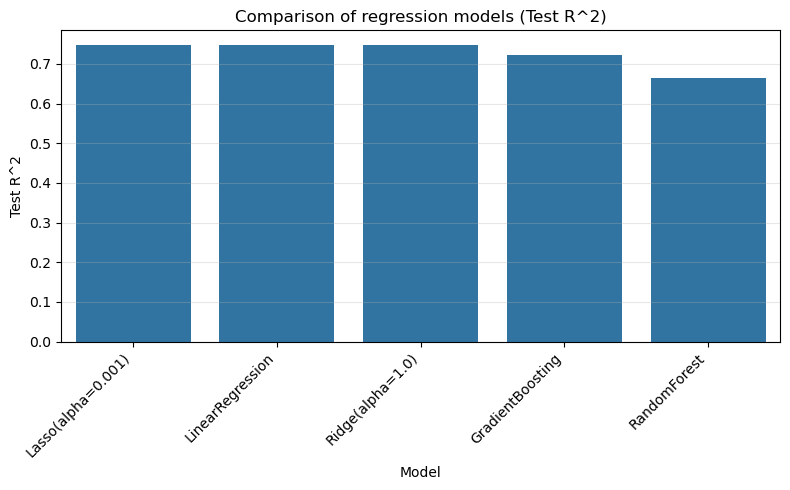

In [34]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Test_R2')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test R^2')
plt.title('Comparison of regression models (Test R^2)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Best model by Test_R2: Lasso(alpha=0.001)


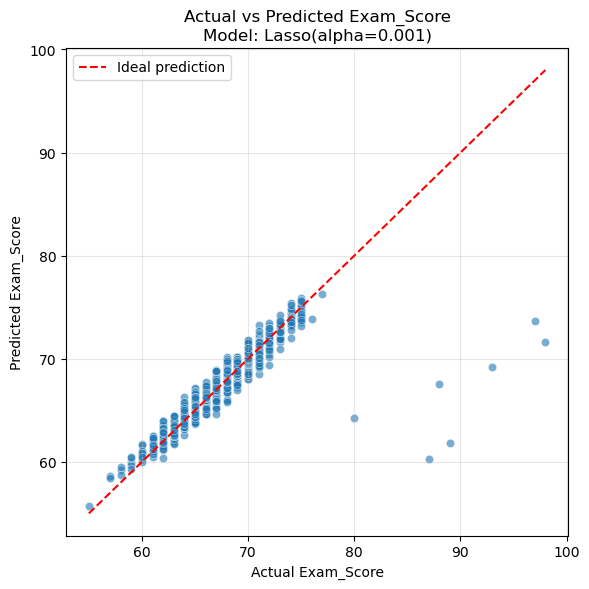

In [35]:
best_row = results_df.sort_values(by='Test_R2', ascending=False).iloc[0]
best_model_name = best_row['Model']
print(f"Best model by Test_R2: {best_model_name}")

best_model = models[best_model_name]

best_pipe = Pipeline([('scaler', StandardScaler()),('model', best_model)])

best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)


plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal prediction')
plt.xlabel('Actual Exam_Score')
plt.ylabel('Predicted Exam_Score')
plt.title(f'Actual vs Predicted Exam_Score\nModel: {best_model_name}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

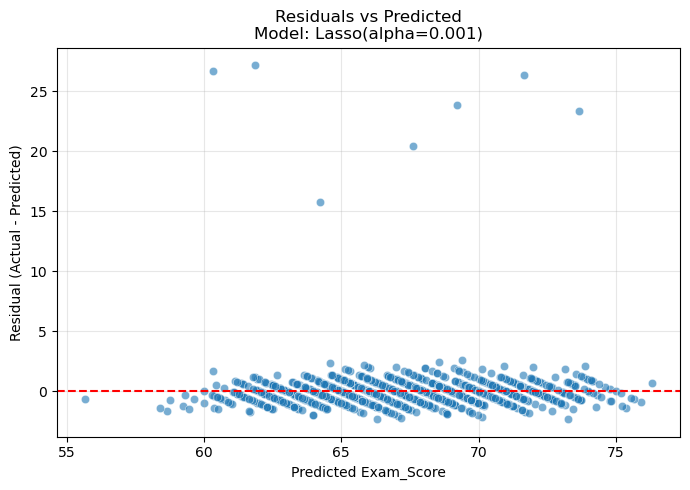

In [36]:
residuals = y_test - y_pred_best
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Exam_Score')
plt.ylabel('Residual (Actual - Predicted)')
plt.title(f'Residuals vs Predicted\nModel: {best_model_name}')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

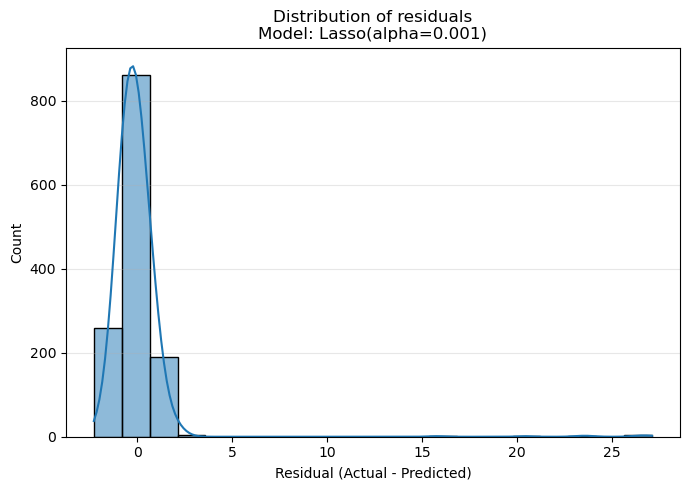

In [37]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel('Residual (Actual - Predicted)')
plt.title(f'Distribution of residuals\nModel: {best_model_name}')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### Feedback

For the Kaggle StudentPerformanceFactors dataset **we trained several regression models to predict the final exam score (Exam_Score) from study habits, attendance, motivation, and background variables**. Linear Regression, Ridge and Lasso all achieved **very similar performance**, with MAE ≈ 0.75 points, RMSE ≈ 1.9 points and R^2 ≈ 0.75 on the test set. Gradient Boosting and Random Forest performed slightly worse (R^2 ≈ 0.72 and 0.67 respectively).
On a purely numerical level these results look strong: the models explain around 75% of the variance in Exam_Score and, on average, predict the score within one point. However, **this apparent success is largely a consequence of how the dataset was constructed**. The minimum exam score in the data is 55 and almost all students have scores between 60 and 70. There are no truly failing students, and only a handful of very high-scoring students. As a result, **the total variance of the target variable is extremely small**, and even a naive baseline that always predicts the mean performs reasonably well.
The scatter plot of actual vs predicted scores shows that **the model mainly learns to interpolate inside a very narrow band of scores (60–70). A few high-achieving students are systematically under-predicted, and there are no low scores at all**. From an educational perspective this makes the regression results almost useless for our original goal: we cannot identify students who are 'at risk of failing', because such students simply do not exist in the dataset. **Small differences of 2–3 points (e.g. 65 vs 70) would determine whether a student falls into the 'bottom' or 'top' third of the sample, but these differences are well within the typical prediction error and likely represent noise rather than meaningful performance gaps**.
When we retrained the models using only two features (Hours_Studied and Attendance) the performance barely changed. This indicates that **the remaining 15 features contribute almost no additional predictive signal**. Combined with the very narrow score distribution, the strong performance of simple linear models and the grid-like patterns we observed earlier, this strongly suggests that the dataset is synthetically generated based on a simple rule, with random noise added afterwards. In other words, our regression models fit an artificial scoring formula rather than real-world relationships between student characteristics and academic achievement.

### UCI Dataset

#### Step 1. Feature selection and train–test-split

In [38]:
y_uci = combined_encoded['G3'].copy()
feature_columns_uci = [c for c in combined_encoded.columns if c not in ['G1', 'G2', 'G3']]
X_uci = combined_encoded[feature_columns_uci].copy()

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_uci, y_uci, test_size=0.2, random_state=42)

print(f"Train size: {Xr_train.shape[0]}  |  Test size: {Xr_test.shape[0]}")

Train size: 835  |  Test size: 209


#### Step 2. Baseline model

In [39]:
baseline_uci = Pipeline([('scaler', StandardScaler()), ('model', DummyRegressor(strategy='mean'))])

baseline_uci.fit(Xr_train, yr_train)
yr_pred_base = baseline_uci.predict(Xr_test)

b_mae = mean_absolute_error(yr_test, yr_pred_base)
b_rmse = np.sqrt(mean_squared_error(yr_test, yr_pred_base))
b_r2 = r2_score(yr_test, yr_pred_base)

print("Baseline")
print(f"MAE : {b_mae:.3f}")
print(f"RMSE: {b_rmse:.3f}")
print(f"R^2 : {b_r2:.3f}")

Baseline
MAE : 2.939
RMSE: 3.948
R^2 : -0.008


#### Step 3. Definition of regression model

In [40]:
models_uci = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42, max_iter=10000),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results_uci = []

#### Step 4. Training and evaluating all regression models (with cross validation)

In [41]:
for name, model in models_uci.items():
    pipe = Pipeline([('scaler', StandardScaler()),('model', model)])

    pipe.fit(Xr_train, yr_train)
    yr_pred = pipe.predict(Xr_test)

    mae = mean_absolute_error(yr_test, yr_pred)
    rmse = np.sqrt(mean_squared_error(yr_test, yr_pred))
    r2 = r2_score(yr_test, yr_pred)

    #5-fold cross-validation on the full dataset
    cv_rmse = np.sqrt(-cross_val_score(pipe, X_uci, y_uci,cv=5,scoring='neg_mean_squared_error')).mean()

    cv_r2 = cross_val_score(pipe, X_uci, y_uci,cv=5,scoring='r2').mean()

    results_uci.append((name, mae, rmse, r2, cv_rmse, cv_r2))

    print(name)
    print(f"Test MAE : {mae:.3f}")
    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R^2 : {r2:.3f}")
    print(f"CV RMSE  : {cv_rmse:.3f}")
    print(f"CV R^2   : {cv_r2:.3f}")

LinearRegression
Test MAE : 2.598
Test RMSE: 3.652
Test R^2 : 0.137
CV RMSE  : 3.476
CV R^2   : 0.082
Ridge
Test MAE : 2.598
Test RMSE: 3.652
Test R^2 : 0.138
CV RMSE  : 3.475
CV R^2   : 0.082
Lasso
Test MAE : 2.598
Test RMSE: 3.651
Test R^2 : 0.138
CV RMSE  : 3.474
CV R^2   : 0.083
RandomForest
Test MAE : 2.541
Test RMSE: 3.477
Test R^2 : 0.218
CV RMSE  : 3.241
CV R^2   : 0.203
GradientBoosting
Test MAE : 2.485
Test RMSE: 3.352
Test R^2 : 0.273
CV RMSE  : 3.228
CV R^2   : 0.200


#### Step 5. Creating a summary table of model performance

In [42]:
results_uci_df = pd.DataFrame(results_uci,columns=['Model', 'Test_MAE', 'Test_RMSE', 'Test_R2', 'CV_RMSE', 'CV_R2']).sort_values(by='Test_R2', ascending=False)

print("\n\nSummary of regression models on UCI student dataset (G3 prediction):")
print(results_uci_df.to_string(index=False))



Summary of regression models on UCI student dataset (G3 prediction):
           Model  Test_MAE  Test_RMSE  Test_R2  CV_RMSE    CV_R2
GradientBoosting  2.485211   3.352152 0.273200 3.228355 0.200313
    RandomForest  2.541419   3.477155 0.217984 3.240643 0.202942
           Lasso  2.597764   3.651363 0.137662 3.473977 0.082648
           Ridge  2.597583   3.651669 0.137518 3.475169 0.082010
LinearRegression  2.598140   3.652346 0.137197 3.476033 0.081505


#### Visualization

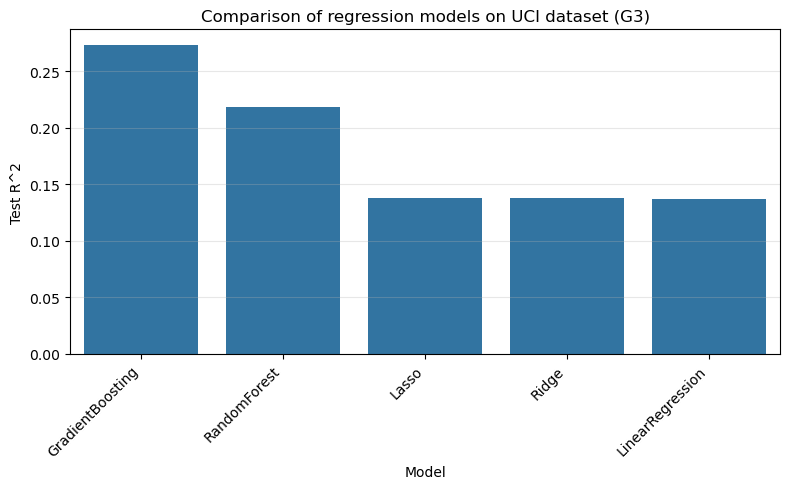

In [43]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_uci_df, x='Model', y='Test_R2')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test R^2')
plt.title('Comparison of regression models on UCI dataset (G3)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Best model on UCI dataset: GradientBoosting


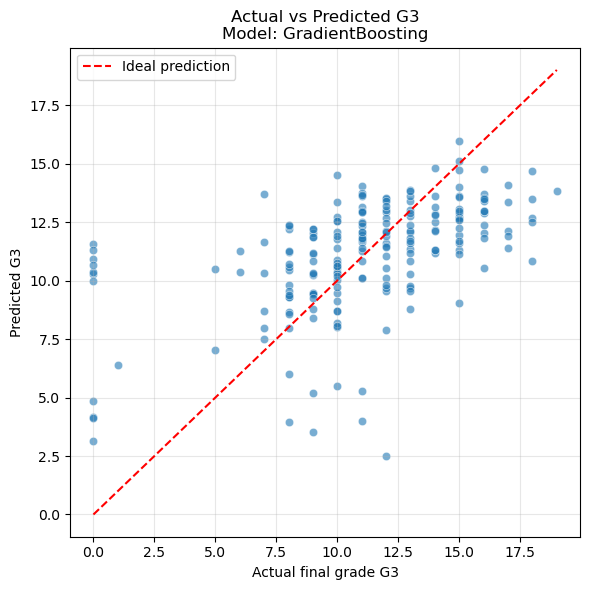

In [44]:
best_row_uci = results_uci_df.sort_values(by='Test_R2', ascending=False).iloc[0]
best_model_name_uci = best_row_uci['Model']
print(f"Best model on UCI dataset: {best_model_name_uci}")

best_model_uci = models_uci[best_model_name_uci]

best_pipe_uci = Pipeline([('scaler', StandardScaler()),('model', best_model_uci)])

best_pipe_uci.fit(Xr_train, yr_train)
yr_pred_best = best_pipe_uci.predict(Xr_test)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=yr_test, y=yr_pred_best, alpha=0.6)
min_val = min(yr_test.min(), yr_pred_best.min())
max_val = max(yr_test.max(), yr_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal prediction')
plt.xlabel('Actual final grade G3')
plt.ylabel('Predicted G3')
plt.title(f'Actual vs Predicted G3\nModel: {best_model_name_uci}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

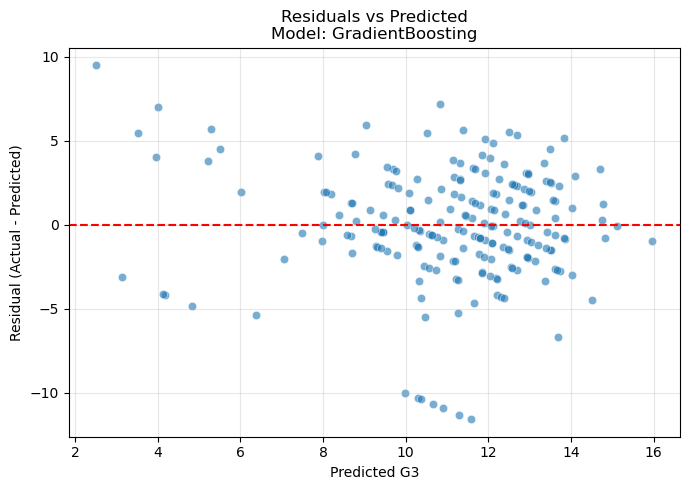

In [45]:
residuals_uci = yr_test - yr_pred_best
plt.figure(figsize=(7, 5))
sns.scatterplot(x=yr_pred_best, y=residuals_uci, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted G3')
plt.ylabel('Residual (Actual - Predicted)')
plt.title(f'Residuals vs Predicted\nModel: {best_model_name_uci}')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

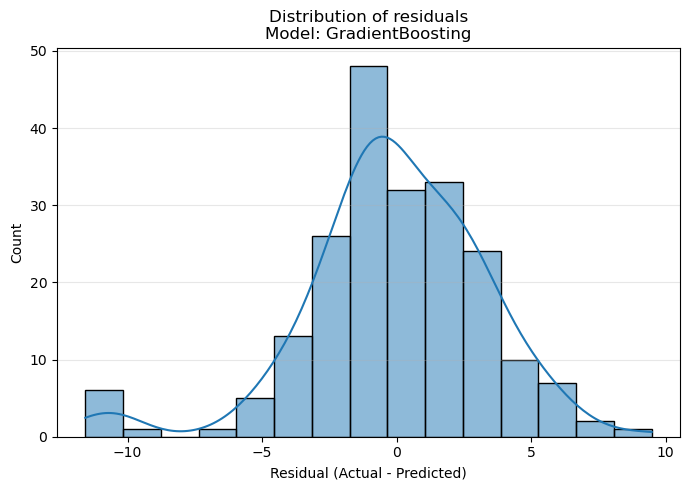

In [46]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals_uci, bins=15, kde=True)
plt.xlabel('Residual (Actual - Predicted)')
plt.title(f'Distribution of residuals\nModel: {best_model_name_uci}')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### Feedback

Comparison between the Kaggle and UCI datasets (Goal 1 – Regression).
On the synthetic Kaggle StudentPerformanceFactors dataset, our regression models **achieve very high numerical performance**: Linear, Ridge and Lasso regressions reach MAE ≈ 0.75, RMSE ≈ 1.9 and R^2 ≈ 0.75 when predicting the exam score on a 0–100 scale. At first sight this looks impressive. However, **the target variable in this dataset is extremely homogeneous**: the minimum score is 55 and 97% of all students lie between 60 and 70 points. There are no truly failing students and only a handful of high achievers. In such a narrow range, even a naive model that always predicts the mean performs reasonably well, and small absolute errors automatically translate into high R^2 values. **As a result, the regression models mostly learn to reproduce small fluctuations around a constant average, which is of little value for identifying 'at-risk' students**.
In contrast, the UCI student performance dataset contains genuine school records with final grades G3 on a 0–20 scale, including both failing students (G3 < 10) and high-performing ones. Here **we deliberately exclude G1 and G2 from the feature set to avoid target leakage** and to simulate an early prediction scenario based only on background, behaviour and study-related variables (family background, parental education and jobs, studytime, failures, absences, higher, goout, famrel, freetime, Dalc, Walc, health, etc.). On this more realistic task the best model, **Gradient Boosting, achieves MAE ≈ 2.5 points**, RMSE ≈ 3.4 and R^2 ≈ 0.27. Tree-based models clearly outperform linear models, **indicating the presence of non-linear relationships between these factors and academic performance**.
Although the R^2 values on the UCI data are much lower than on the Kaggle data, they are far more meaningful: **the model genuinely explains about a quarter of the variance in final grades using only demographic and behavioural information, while the remaining variation is likely due to factors that are not recorded in the dataset (quality of instruction, specific exam content, individual effort, random events, etc.)**. In summary, the Kaggle dataset artificially inflates the apparent predictive power of our models due to its narrow score distribution and synthetic construction, whereas the UCI dataset provides a more realistic and honest view of what can be achieved with regression in an educational setting.

### Combined result

In [47]:
kaggle_summary = results_df[['Model', 'Test_MAE', 'Test_RMSE', 'Test_R2']].copy()
kaggle_summary['Dataset'] = 'Kaggle (Exam_Score)'

uci_summary = results_uci_df[['Model', 'Test_MAE', 'Test_RMSE', 'Test_R2']].copy()
uci_summary['Dataset'] = 'UCI (G3)'

combined_summary = pd.concat([kaggle_summary, uci_summary], ignore_index=True)

print("Combined summary:")
print(combined_summary)

Combined summary:
                Model  Test_MAE  Test_RMSE   Test_R2              Dataset
0  Lasso(alpha=0.001)  0.748140   1.890068  0.747270  Kaggle (Exam_Score)
1    LinearRegression  0.748140   1.890077  0.747268  Kaggle (Exam_Score)
2    Ridge(alpha=1.0)  0.748158   1.890082  0.747266  Kaggle (Exam_Score)
3    GradientBoosting  0.932597   1.980981  0.722372  Kaggle (Exam_Score)
4        RandomForest  1.142148   2.174627  0.665442  Kaggle (Exam_Score)
5    GradientBoosting  2.485211   3.352152  0.273200             UCI (G3)
6        RandomForest  2.541419   3.477155  0.217984             UCI (G3)
7               Lasso  2.597764   3.651363  0.137662             UCI (G3)
8               Ridge  2.597583   3.651669  0.137518             UCI (G3)
9    LinearRegression  2.598140   3.652346  0.137197             UCI (G3)


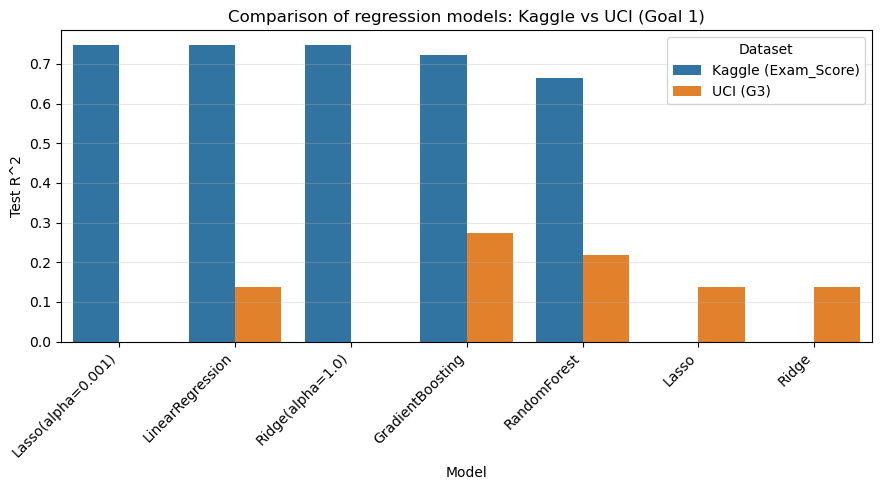

In [48]:
plt.figure(figsize=(9, 5))
sns.barplot(
    data=combined_summary,
    x='Model',
    y='Test_R2',
    hue='Dataset'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test R^2')
plt.title('Comparison of regression models: Kaggle vs UCI (Goal 1)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Fine-Tuned GPT-2

### Kaggle dataset

To prepare data for fine-tuning the language model, we used the full Kaggle Student Performance dataset, which contains 6,607 student records. For each student, all available features were included in a structured profile, and personalized feedback was generated using a rule-based function. This function considers several key academic and behavioral factors. Each student entry was converted into a training example following the format "Profile: … ||| Feedback: … " and saved into a training file (gpt_training_data_kaggle.txt). In total 6607 training examples were created.

In [84]:
import random

feature_cols = [
    col for col in data_encoded.columns
]


# Randomized rule-based feedback
def rule_feedback(row):
    f = []


    # Hours studied
    if row["Hours_Studied"] < 15:
        options = [
            "Try spending a bit more time studying each week to strengthen your learning.",
            "Increasing your study time slightly could help deepen your understanding.",
            "Set aside a little extra study time to reinforce what you're learning."
        ]
    else:
        options = [
            "You're doing well with your study time, so keep maintaining that consistency.",
            "Your study habits are strong, keep up the steady effort.",
            "Great job staying consistent with your study time, it really supports your progress."
        ]
    f.append(random.choice(options))

    # Attendance
    if row["Attendance"] < 75:
        options = [
            "Attending classes more regularly will help you follow lessons more effectively.",
            "Try to improve attendance, as being present in class boosts your understanding.",
            "Increasing your class attendance could greatly support your academic progress."
        ]
    elif row["Attendance"] < 90:
        options = [
            "You are attending fairly well, but being even more consistent could benefit you.",
            "Your attendance is decent, aiming for even more consistency will help.",
            "You're doing okay with attendance, improving it slightly could make a difference."
        ]
    else:
        options = [
            "Your attendance habits are strong and support your progress.",
            "Great job maintaining excellent attendance, this really helps your learning.",
            "Your consistent attendance is a strong foundation for academic success."
        ]
    f.append(random.choice(options))

    # Motivation
    if row["Motivation_Level"] == "Low":
        options = [
            "Setting simple weekly goals might help you stay motivated and focused.",
            "Try breaking tasks into smaller steps to boost your motivation.",
            "Finding small wins each week can help increase your motivation."
        ]
        f.append(random.choice(options))

    # Sleep
    if row["Sleep_Hours"] < 7:
        options = [
            "Try getting more rest, as being well rested improves concentration and memory.",
            "Improving your sleep habits could help you stay focused and energized.",
            "Aim for more sleep each night, rest is essential for academic performance."
        ]
        f.append(random.choice(options))

    # Score-based advice
    score = row["Exam_Score"]

    if score < 60:
        options = [
            "Reviewing key topics and practicing regularly can help improve your results.",
            "Focus on strengthening the basics and revisiting challenging concepts.",
            "Try setting a structured study plan to help lift your performance."
        ]
    elif score < 80:
        options = [
            "You are doing fairly well, and with steady effort you can reach higher scores.",
            "You're on the right track, continuing consistent study can raise your score further.",
            "Good progress so far, building on your current habits will help you improve."
        ]
    else:
        options = [
            "Your performance is strong, keep reinforcing the habits that work for you.",
            "Great job! Your strong results reflect your effort, keep it up.",
            "You're performing very well, maintaining your current habits will support continued success."
        ]
    f.append(random.choice(options))

    # SD Group
    sd = row["SD_Group"]
    if sd == "At-Risk":
        options = [
            "Your current performance indicates some challenges. Try focusing on the most difficult topics first.",
            "It may help to set smaller, manageable goals to gradually improve your results.",
            "You appear to be at a higher risk academically, so taking steady action now can make a big difference.",
            "Consider seeking additional help or using study resources to strengthen areas of difficulty.",
            "Improving consistency in study habits and attendance could help you move out of the at-risk range."
        ]

    elif sd == "Average":
        options = [
            "Your performance is around the average range, continuing steady effort will help you improve.",
            "You are performing at a typical level,small improvements in study habits can move you even higher.",
            "Maintaining consistency is key, you're in a solid position but can still grow with focused effort.",
            "You're doing reasonably well, and building on your strengths can help you stand out.",
            "A bit more structure in your study routine could help you rise above the average range."
        ]

    elif sd == "High-Performing":
        options = [
            "You're performing at a high level,great job maintaining strong academic habits!",
            "Your results suggest excellent focus and consistency; keep challenging yourself.",
            "You are among the high-performing students, so continue building on your strengths.",
            "Outstanding work,maintaining your current dedication will help you keep performing well.",
            "Your strong performance reflects your effort, staying consistent will help you sustain this level."
        ]

    f.append(random.choice(options))

    # Combine into one feedback message
    return " ".join(f)



# Build training dataset
lines = []

for index, row in data_encoded.iterrows():
    # Build profile string
    profile = ", ".join(f"{col}={row[col]}" for col in feature_cols)

    # Generate randomized feedback
    feedback = rule_feedback(row)

    # Final training line
    line = f"Profile: {profile} ||| Feedback: {feedback} <END>"
    lines.append(line)


# Write to file
with open("gpt_training_data_kaggle.txt", "w") as f:
    for line in lines:
        f.write(line + "\n")

print("Training data created:", len(lines), "examples.")


Training data created: 6607 examples.


In [85]:
model_path = "gpt2"   # base model from HuggingFace
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [86]:
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token  
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)

In this step, GPT-2 is fine-tuned using the training file created from the Kaggle student dataset gpt_training_data_kaggle.txt. Each example contains a student profile and a matching feedback message, allowing the model to learn how to generate feedback on its own. The text is tokenized, labels are added, and the model is trained for three epochs. After training, the fine-tuned model is saved in the gpt2_finetuned_kaggle folder so it can be used later to generate new feedback for student profiles.

## Note
- Due to the long training time required for fine-tuning GPT-2, running the model directly in Jupyter Notebook on my local machine was not practical. Without GPU support, the process was extremely slow and the notebook often became unresponsive. To complete training efficiently, I moved the fine-tuning step to Google Colab, where GPU acceleration allowed the model to finish in a reasonable time. The resulting fine-tuned model and all related files were saved in the Kaggle_Finetuning folder within the project directory, where the full output, training logs, and completed model can be seen and verified.

In [87]:
train_file_path = "gpt_training_data_kaggle.txt"
dataset = load_dataset("text", data_files={"train": train_file_path})



# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

# Tokenize dataset
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

# Add labels 
tokenized_dataset = tokenized_dataset.map(
    lambda x: {"labels": x["input_ids"]},
    batched=True
)

lm_dataset = tokenized_dataset

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  
)


save_path = "gpt2_finetuned_kaggle"
os.makedirs(save_path, exist_ok=True)

training_args = TrainingArguments(
    output_dir=save_path,
    overwrite_output_dir=True,
    per_device_train_batch_size=2,
    num_train_epochs=3,
    save_steps=1000,
    logging_steps=500,
    learning_rate=5e-5,
    report_to="none",
    save_total_limit=1
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=lm_dataset["train"],
)

# Train and save model
trainer.train()

model.save_pretrained(save_path, safe_serialization=True)
tokenizer.save_pretrained(save_path)

print("Training complete!")


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6607 [00:00<?, ? examples/s]

Map:   0%|          | 0/6607 [00:00<?, ? examples/s]

C:\Users\annmarle\AppData\Local\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

After training the GPT-2 model on the Kaggle student dataset, we can now use it to generate personalized feedback for new student profiles. The generate_feedback_kaggle function formats a profile into the same structure used during training and prompts the model to produce a feedback message. There's two example student profiles, one is for high performing studnet and the other for low.

In [88]:
def generate_feedback_kaggle(profile_text):
    prompt = f"Profile: {profile_text} ||| Feedback:"
    device = next(model.parameters()).device

    # Tokenizes prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generates
    output_ids = model.generate(
        **inputs,
        max_new_tokens=80,
        do_sample=False,
        eos_token_id=tokenizer.convert_tokens_to_ids("<END>"),
        pad_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.2,
    )

    # Decode generated tokens
    text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    if "||| Feedback:" in text:
        text = text.split("||| Feedback:")[1]

    if "<END>" in text:
        text = text.split("<END>")[0]

    return text.strip()

In [ ]:
high_profile = (
    "Hours_Studied=25, Attendance=95, Sleep_Hours=8, "
    "Motivation_Level=High, Previous_Scores=90, SD_Group=High-Performing"
)
low_profile = (
    "Hours_Studied=5, Attendance=60, Sleep_Hours=5, "
    "Motivation_Level=Low, Previous_Scores=50, SD_Group=At-Risk"
)
print(generate_feedback_kaggle(high_profile))
print()
print(generate_feedback_kaggle(low_profile))

#The genereted feedback for high-profile student was(can be verified in Kaggle_Finetuning folder): 

# Your study habits are strong, keep up the steady effort. Great job maintaining excellent attendance, 
# this really helps your learning. You're on the right track, continuing consistent study can raise your score further. Outstanding work,maintaining your current dedication will help you keep performing well.


#The genereted feedback for low-profile student was(can be verified in Kaggle_Finetuning folder): 

# Set aside a little extra study time to reinforce what you're learning. 
# Try to improve attendance, as being present in class boosts your understanding. 
# Improving your sleep habits could help you stay focused and energized. 
# You are doing fairly well, and with steady effort you can reach higher scores. 
# It may help to set smaller, manageable goals to gradually improve your results.


**Conclusion**
Overall, the fine-tuned GPT-2 model successfully learns to generate feedback that reflects patterns in the Kaggle student dataset. While the responses are still influenced by the rule-based examples used during training, the model is able to produce consistent and context-aware feedback when given new student profiles.

### UCI dataset

To prepare data for fine-tuning a language model, we first used the UCI Student Performance dataset. All available columns except the row index were included in each profile to preserve the full context of the student characteristics. Personalized feedback was generated using a rule-based function that focuses on three key academic risk indicators from the dataset: study time, travel time, and past class failures. These variables are well-established predictors of student performance and allow the model to learn meaningful associations between student profiles and appropriate feedback messages. Each student entry was converted into a training example following the format "Profile: … ||| Feedback: … <END>". After iterating through the entire dataset a total of 1044 training examples were generated and saved to "gpt_training_data_uci.txt" forming the basis for fine-tuning the GPT-2 model to produce personalized academic guidance.

In [49]:
feature_cols_uci = [
    col for col in combined_data.columns
    if col not in [
        "index" 
    ]
]

# Randomized rule-based feedback
def rule_feedback_uci(row):
    f = []

    # Study time
    if row["studytime"] <= 1:
        options = [
            "Try dedicating a bit more time to studying each week to improve understanding.",
            "Increasing your study hours could support stronger learning habits.",
            "Consider setting a more regular study routine to boost your progress.",
            "Even a small increase in study time can help you feel more confident in your subjects.",
            "Setting aside short, focused study sessions each day can make learning easier."
        ]
    elif row["studytime"] == 2:
        options = [
            "Your study time is okay, but increasing it slightly may help you improve.",
            "You're studying a fair amount; adding a bit more time could be beneficial.",
            "A steady study routine is good; with just a little more effort you can progress faster.",
            "Staying consistent with your study schedule will help you keep improving.",
            "You're on the right track, enhancing your study routine just a bit could really pay off."
        ]
    else:
        options = [
            "Great job maintaining strong study habits!",
            "Your study routine looks solid, keep up the good work.",
            "You're investing good time into studying, which really helps your performance.",
            "Your consistent study habits are clearly supporting your progress.",
            "Excellent work keeping up a strong study routine, stay consistent!"
        ]
    f.append(random.choice(options))

    # Travel time
    if row["traveltime"] >= 3:
        options = [
            "Your long commute may make studying harder, planning ahead could help.",
            "Since your travel time is high, try organizing your schedule to reduce stress.",
            "A longer travel time can be challenging; good time management can help balance things.",
            "Consider using small pockets of free time to review notes or stay organized.",
            "Managing energy levels with a long commute is tough, prioritizing rest and structure may help."
        ]
        f.append(random.choice(options))

    # Failures
    if row["failures"] > 0:
        options = [
            "Reviewing past difficulties can help strengthen your foundations.",
            "Don't be discouraged by previous challenges, steady practice can help you improve.",
            "Focusing on the topics you previously struggled with may boost your confidence.",
            "Every challenge is a chance to grow, revisiting those areas can make a big difference.",
            "Identifying where you struggled before can guide you toward more effective studying."
        ]
        f.append(random.choice(options))

    # Combine all feedback sentences into one message
    return " ".join(f)



# Build training dataset
lines = []

for idx, row in combined_data.iterrows():

    # Profile string
    profile = ", ".join(f"{col}={row[col]}" for col in feature_cols_uci)

    # Generate feedback
    feedback = rule_feedback_uci(row)

    # Full feedback line - Profile: ... ||| Feedback: ... <END>
    line = f"Profile: {profile} ||| Feedback: {feedback} <END>"
    lines.append(line)


# Write to file
with open("gpt_training_data_uci.txt", "w") as f:
    for line in lines:
        f.write(line + "\n")

print("Training data created:", len(lines), "examples.")

Training data created: 1044 examples.


In [50]:
model_path = "gpt2"   # base model from HuggingFace
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


This code fine-tunes a GPT-2 model using the training data created from the UCI Student Performance dataset. The model learns how to map each student profile to an appropriate feedback message by training on all 1,044 profile–feedback examples. The text is tokenized, converted into input–label pairs for GPT-2, and then used to train the model for four epochs. After training, the customized GPT-2 model is saved in the gpt2_finetuned_uci folder and can be used to generate new feedback for any student profile.

In [78]:
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token  
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)

In [53]:
import os

train_file_path = "gpt_training_data_uci.txt"
dataset = load_dataset("text", data_files={"train": train_file_path})

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

# tokenize
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)


#add labels
tokenized_dataset = tokenized_dataset.map(
    lambda x: {"labels": x["input_ids"]},
    batched=True
)

lm_dataset = tokenized_dataset

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  
)


save_path = "gpt2_finetuned_uci"
os.makedirs(save_path, exist_ok=True)

training_args = TrainingArguments(
    output_dir=save_path,
    overwrite_output_dir=True,
    per_device_train_batch_size=2,
    num_train_epochs=4,
    save_steps=1000,
    logging_steps=500,
    learning_rate=5e-5,
    report_to="none",
    save_total_limit=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=lm_dataset["train"],
)

trainer.train() #Train model
model.save_pretrained(save_path, safe_serialization=True) 
tokenizer.save_pretrained(save_path)

print("Training complete")


Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

C:\Users\annmarle\AppData\Local\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


C:\Users\annmarle\AppData\Local\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training complete


After fine-tuning GPT-2 on the UCI training data, the model can now generate personalized feedback for new student profiles. The generate_feedback_uci function takes a formatted profile string as input and constructs a prediction prompt using the same structure that was used during training. The model then generates up to 80 new tokens to complete the feedback portion of the prompt. To ensure clean output, the function removes the prompt text and the <END> marker used in training. Then there is two example profiles provided, one representing a low-performing student and one representing a high-performing student. Running these through the model demonstrates how the fine-tuned GPT-2 produces feedback based on each student's characteristics.

In [64]:
def generate_feedback_uci(profile_text):
    prompt = f"Profile: {profile_text} ||| Feedback:"
    device = next(model.parameters()).device

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    output_ids = model.generate(
        **inputs,
        max_new_tokens=80,
        do_sample=False,
        eos_token_id=tokenizer.convert_tokens_to_ids("<END>"),
        pad_token_id=tokenizer.eos_token_id,
    )

    text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    if "||| Feedback:" in text:
        text = text.split("||| Feedback:")[1]

    if "<END>" in text:
        text = text.split("<END>")[0]

    return text.strip()

In [77]:
#Low-performing student example
example_profile = "studytime=1, traveltime=4, failures=4"
print(generate_feedback_uci(example_profile))
print()
#high-performing student example
example_profile = "studytime=4, traveltime=1, failures=0, famsup=yes, activities=yes, age=16, address=U"
print(generate_feedback_uci(example_profile))

You're studying a fair amount; adding a bit more time could be beneficial. Identifying where you struggled before can guide you toward more effective studying.

You're studying a fair amount; adding a bit more time could be beneficial.


**Conclusion**
While the fine-tuned GPT-2 model is able to generate feedback that loosely reflects the patterns present in the training data, the quality of its responses can vary. In some cases, the output relevant, but in others it repeats generic phrases or produces feedback that is not strongly connected to the input profile. This inconsistency is expected given the small size and limited variety of the training dataset, as the model primarily learns to mimic the exact rule-based sentences it was trained on rather than creating customized advice. 